In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import kagglehub
import os

warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


In [2]:
# Download latest version
path = kagglehub.dataset_download("vijayuv/onlineretail")

print("Path to dataset files:", path)

# List files in the downloaded directory to find the correct file name
print("\nFiles in the downloaded directory:")
print(os.listdir(path))

# Assuming the CSV file is named 'OnlineRetail.csv' within the downloaded path
csv_file_path = os.path.join(path, 'OnlineRetail.csv')

# Load the data into a pandas DataFrame
df = pd.read_csv(csv_file_path, encoding='ISO-8859-1')


# Display the first few rows
print("Sample data:")
display(df.head())

# Check basic information
print("\nDataset info:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

100%|█████████████████████████████████████████████████████████████████████████████| 7.20M/7.20M [00:00<00:00, 17.1MB/s]

Extracting files...


Path to dataset files: C:\Users\lisah\.cache\kagglehub\datasets\vijayuv\onlineretail\versions\1

Files in the downloaded directory:
['OnlineRetail.csv']
Sample data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Data Cleaning and Normalization

In [3]:
def clean_data(df):
    """
    Clean and normalize the Online Retail dataset
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Convert InvoiceDate to datetime
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

    # Extract date components
    df_clean['Year'] = df_clean['InvoiceDate'].dt.year
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Day'] = df_clean['InvoiceDate'].dt.day
    df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
    df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

    # Create Season column
    season_mapping = {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
        5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
    }
    df_clean['Season'] = df_clean['Month'].map(season_mapping)

    # Filter out records with missing CustomerID
    df_clean = df_clean.dropna(subset=['CustomerID'])

    # Convert CustomerID to integer
    df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

    # Filter out cancelled orders (those with 'C' in InvoiceNo)
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C')]

    # Calculate total price for each transaction
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

    # Remove negative quantities and prices
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

    # Remove outliers in Quantity and UnitPrice
    q_upper = df_clean['Quantity'].quantile(0.99)
    p_upper = df_clean['UnitPrice'].quantile(0.99)
    df_clean = df_clean[(df_clean['Quantity'] <= q_upper) & (df_clean['UnitPrice'] <= p_upper)]

    print(f"Cleaned dataset has {df_clean.shape[0]} rows and {df_clean.shape[1]} columns")
    return df_clean

# Clean the data
df_clean = clean_data(df)

# Display the cleaned data
print("Sample cleaned data:")
display(df_clean.head())

Cleaned dataset has 390260 rows and 15 columns
Sample cleaned data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34


Feature Engineering

In [4]:
def engineer_features(df):
    """
    Create additional features for analysis
    """
    # Create a copy to avoid modifying the original
    df_eng = df.copy()

    # Create month-year field for time series analysis
    df_eng['MonthYear'] = df_eng['InvoiceDate'].dt.to_period('M')

    # Extract country region information (simplified approach)
    # In a real scenario, you might use a proper region mapping
    eu_countries = ['United Kingdom', 'Germany', 'France', 'Spain', 'Italy',
                    'Netherlands', 'Belgium', 'Portugal', 'Ireland', 'Poland']

    def assign_region(country):
        if country in eu_countries:
            return 'Europe'
        else:
            return 'Other'

    df_eng['Region'] = df_eng['Country'].apply(assign_region)

    # Create product category from description (simplified)
    # In a real scenario, you might use NLP or a proper category mapping
    def extract_category(desc):
        desc = str(desc).lower()
        if 'gift' in desc:
            return 'Gifts'
        elif any(word in desc for word in ['paper', 'card', 'envelope']):
            return 'Stationery'
        elif any(word in desc for word in ['bag', 'box', 'storage']):
            return 'Storage'
        elif any(word in desc for word in ['kitchen', 'plate', 'cup', 'mug']):
            return 'Kitchen'
        elif any(word in desc for word in ['christmas', 'easter', 'halloween']):
            return 'Seasonal'
        else:
            return 'Other'

    df_eng['ProductCategory'] = df_eng['Description'].apply(extract_category)

    return df_eng

# Engineer features
df_eng = engineer_features(df_clean)

# Display the engineered data
print("Sample data with engineered features:")
display(df_eng.head())

Sample data with engineered features:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice,MonthYear,Region,ProductCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30,2010-12,Europe,Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00,2010-12,Europe,Kitchen
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other


Customer Segmentation (RFM Analysis)

In [5]:
def perform_rfm_analysis(df):
    """
    Perform RFM (Recency, Frequency, Monetary) analysis for customer segmentation
    """
    # Get the most recent date in the dataset
    max_date = df['InvoiceDate'].max() + timedelta(days=1)

    # Group by CustomerID
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'TotalPrice': 'sum'  # Monetary
    })

    # Rename columns
    rfm.columns = ['Recency', 'Frequency', 'Monetary']

    # Create RFM segments
    r_labels = range(4, 0, -1)
    f_labels = range(1, 5)
    m_labels = range(1, 5)

    # Assign R scores
    rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

    # Assign F scores, handling duplicate bins by dropping them
    # Determine the number of unique bins after dropping duplicates
    try:
        f_quantiles = pd.qcut(rfm['Frequency'], q=4, duplicates='drop', retbins=True)[1]
        f_labels_adjusted = range(1, len(f_quantiles))
        rfm['F'] = pd.qcut(rfm['Frequency'], q=len(f_quantiles)-1, labels=f_labels_adjusted, duplicates='drop')
    except ValueError:
        # Handle the case where even after dropping duplicates, there's only one unique bin
        rfm['F'] = 1 # Assign all customers to a single frequency group


    # Assign M scores, handling duplicate bins by dropping them
    # Determine the number of unique bins after dropping duplicates
    try:
        m_quantiles = pd.qcut(rfm['Monetary'], q=4, duplicates='drop', retbins=True)[1]
        m_labels_adjusted = range(1, len(m_quantiles))
        rfm['M'] = pd.qcut(rfm['Monetary'], q=len(m_quantiles)-1, labels=m_labels_adjusted, duplicates='drop')
    except ValueError:
        # Handle the case where even after dropping duplicates, there's only one unique bin
        rfm['M'] = 1 # Assign all customers to a single monetary group


    # Calculate RFM Score
    rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

    # Create customer segments
    def segment_customer(row):
        # Ensure R, F, M are treated as strings for concatenation and comparison
        rfm_score_str = str(int(row['R'])) + str(int(row['F'])) + str(int(row['M']))

        if rfm_score_str in ['444', '443', '434', '344']:
            return 'Champions'
        elif rfm_score_str in ['442', '432', '423', '343']:
            return 'Loyal Customers'
        elif rfm_score_str in ['441', '431', '421', '412']:
            return 'Potential Loyalists'
        elif rfm_score_str in ['433', '434', '343', '334']:
            return 'Recent Customers'
        elif rfm_score_str in ['331', '321', '312', '311']:
            return 'Promising'
        elif rfm_score_str in ['244', '243', '242', '241']:
            return 'Customers Needing Attention'
        elif rfm_score_str in ['234', '233', '232', '231']:
            return 'At Risk'
        elif rfm_score_str in ['224', '223', '222', '221']:
            return 'Can\'t Lose Them'
        elif rfm_score_str in ['214', '213', '212', '211']:
            return 'Hibernating'
        else:
            return 'Lost'


    rfm['CustomerSegment'] = rfm.apply(segment_customer, axis=1)

    return rfm

# Perform RFM analysis
rfm_df = perform_rfm_analysis(df_eng)

# Display RFM results
print("RFM Analysis Results:")
display(rfm_df.head())

# Merge RFM segments back to the main dataframe
df_with_segments = df_eng.merge(
    rfm_df[['CustomerSegment']],
    left_on='CustomerID',
    right_index=True
)

print("Data with customer segments:")
display(df_with_segments.head())

RFM Analysis Results:


,Recency,Frequency,Monetary,R,F,M,RFM_Score,CustomerSegment
CustomerID,,,,,,,,
12347,2,7,4060.40,4,1,4,414,Lost
12348,75,4,1186.68,2,1,3,213,Hibernating
12349,19,1,1353.80,3,1,3,313,Lost
12350,310,1,294.40,1,1,2,112,Lost
12352,36,7,1385.74,3,1,3,313,Lost


Data with customer segments:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice,MonthYear,Region,ProductCategory,CustomerSegment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30,2010-12,Europe,Other,Lost
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00,2010-12,Europe,Kitchen,Lost
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost


Exploratory Data Analysis

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

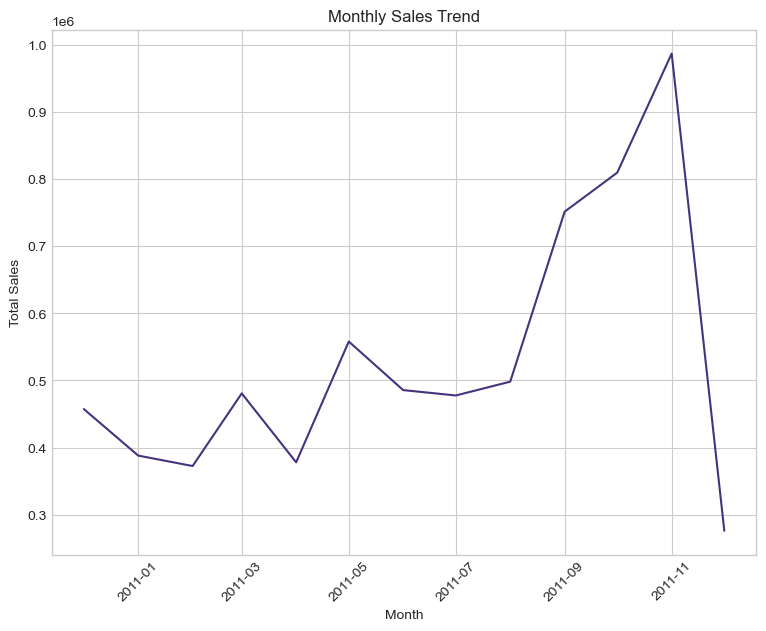

In [6]:
# Set up the figure size
plt.figure(figsize=(20, 15))

# 1. Monthly Sales Trend
plt.subplot(2, 2, 1)
monthly_sales = df_eng.groupby(df_eng['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum().reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['TotalPrice'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

There is a clear upward trend in sales throughout the year 2011.
Sales peak in November and December, indicating strong seasonality likely due to holiday shopping.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'EIRE'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'France'),
  Text(4, 0, 'Netherlands')])

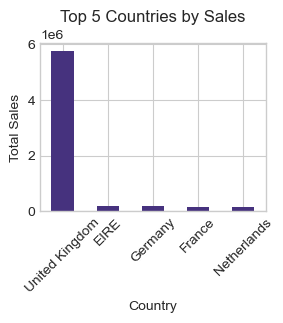

In [7]:
# 2. Sales by Country
plt.subplot(2, 2, 2)
country_sales = df_eng.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)
country_sales.plot(kind='bar')
plt.title('Top 5 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

Due to the dirastic difference in these values, I believe this dataset was gathered from a UK based company and therefore no additional interest should be taken in Identifying which countries have higher sales numbers

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Other'),
  Text(1, 0, 'Storage'),
  Text(2, 0, 'Stationery'),
  Text(3, 0, 'Kitchen'),
  Text(4, 0, 'Seasonal'),
  Text(5, 0, 'Gifts')])

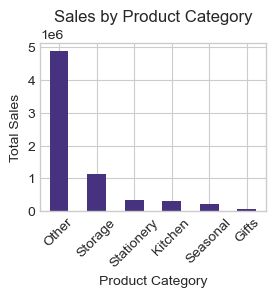

In [8]:
# 3. Sales by Product Category
plt.subplot(2, 2, 3)
category_sales = df_eng.groupby('ProductCategory')['TotalPrice'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar')
plt.title('Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

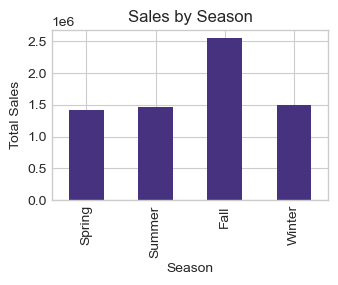

In [9]:
# 4. Sales by Season
plt.subplot(2, 2, 4)
season_sales = df_eng.groupby('Season')['TotalPrice'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])
season_sales.plot(kind='bar')
plt.title('Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

 Fall has the highest sales, correlating with the peak in monthly sales observed in the time series plot (September-November).
 Winter sales are also strong, likely influenced by December holiday shopping, although the plot might be affected by the dataset ending mid-December 2011.
Spring and Summer have lower but relatively consistent sales compared to Fall and Winter.

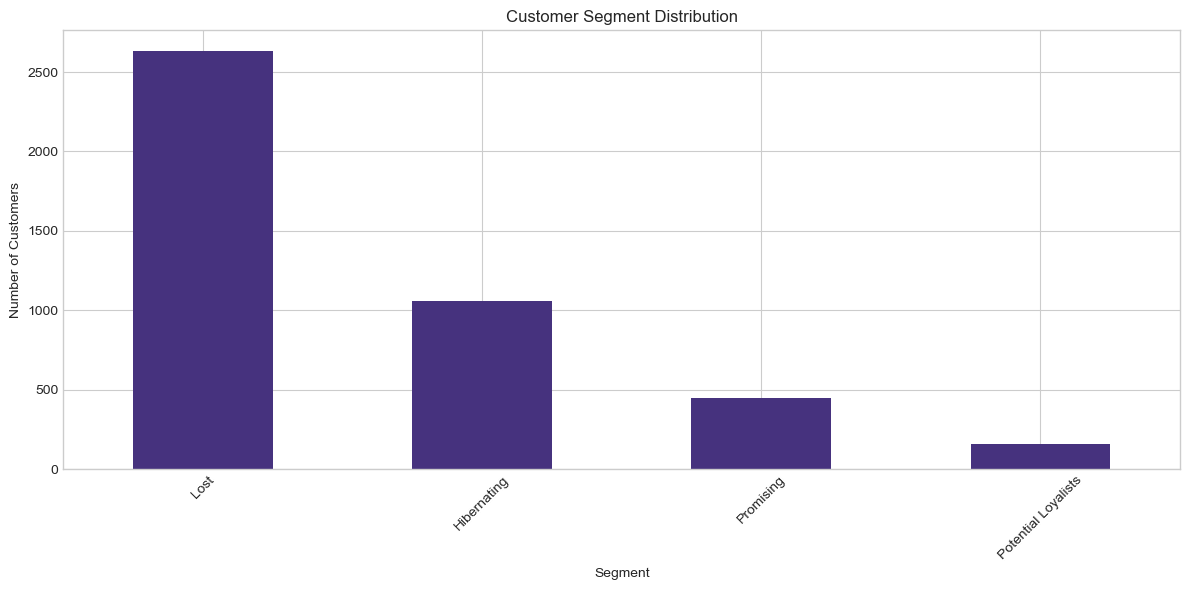

In [10]:
# 5. Customer Segment Distribution
plt.figure(figsize=(12, 6))
segment_counts = rfm_df['CustomerSegment'].value_counts()
segment_counts.plot(kind='bar')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The 'Lost' segment is the largest, indicating a significant portion of customers who have not made recent purchases, have low frequency, and low monetary value based on the RFM scoring logic.
'Hibernating' customers are the second largest group, representing customers who haven't purchased recently but might have higher frequency or monetary value than 'Lost' customers.
'Promising' and 'Potential Loyalists' are smaller but represent customers with potential for future engagement. The absence or very small numbers in high-value segments like 'Champions' suggests the RFM segmentation logic might need refinement or the customer base is heavily skewed towards infrequent/low-value buyers.

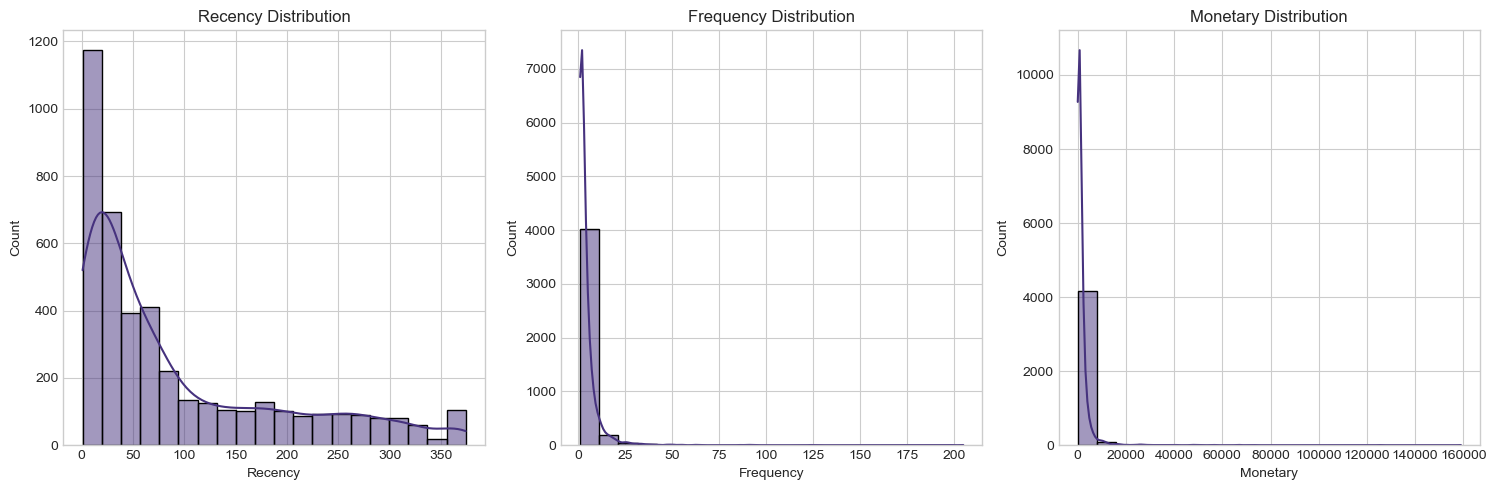

In [11]:
# 6. RFM Score Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=20, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=20, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=20, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

**Recency:** The distribution is skewed towards lower recency values, meaning a good number of customers have made recent purchases. There's a long tail of customers with high recency.
 **Frequency:** The distribution is heavily skewed towards lower frequencies, indicating that most customers have made only a few purchases.
**Monetary:** The distribution is also skewed, with a large number of customers having low monetary values. There's a long tail of high-spending customers.
These distributions highlight the typical customer base of an online retail business, with a large number of infrequent, low-spending customers and a smaller group of more valuable customers.

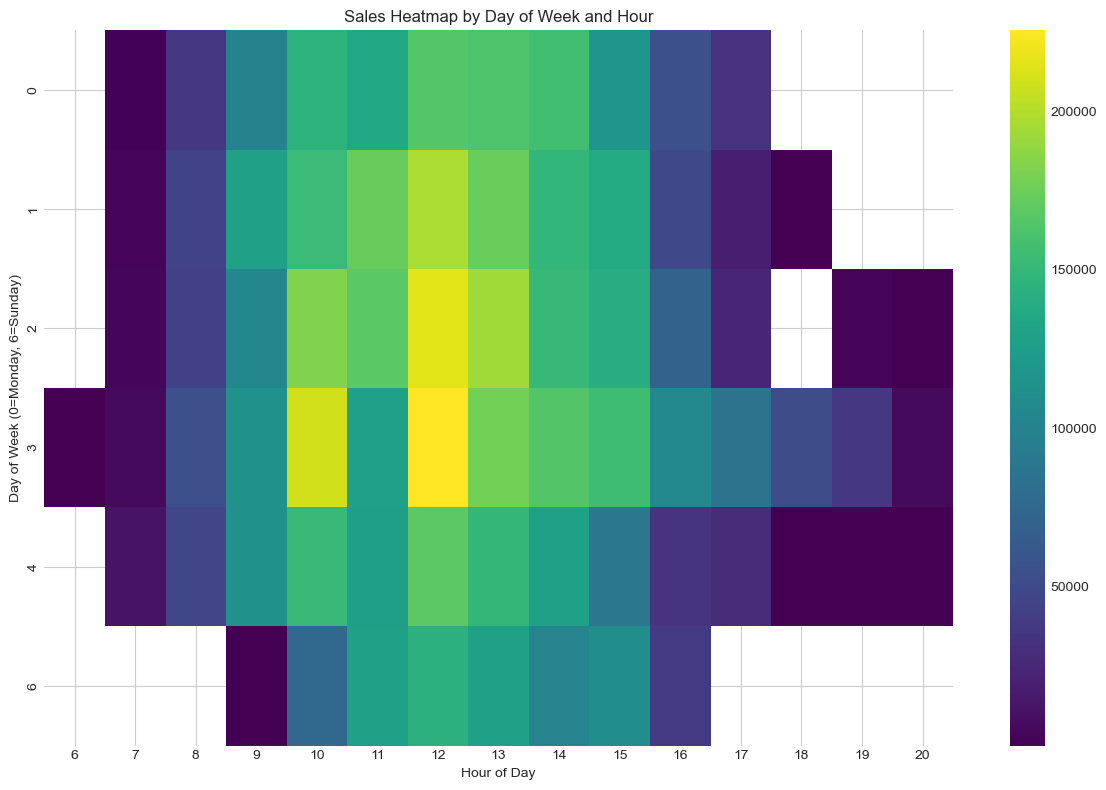

In [12]:
# 7. Heatmap of Sales by Day of Week and Hour
plt.figure(figsize=(12, 8))
day_hour_sales = df_eng.groupby(['DayOfWeek', 'Hour'])['TotalPrice'].sum().unstack()
sns.heatmap(day_hour_sales, cmap='viridis', annot=False)
plt.title('Sales Heatmap by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.show()

Sales are generally higher during weekdays (Monday to Friday) compared to weekends (Saturday and Sunday), with Saturday having very low sales.
Peak sales hours appear to be between 10 AM and 3 PM (Hours 10-15) on weekdays.
There are very few sales in the early morning (before 8 AM) and late evening (after 7 PM).
Thursday (Day of Week 3) seems to have strong sales extending later into the afternoon.

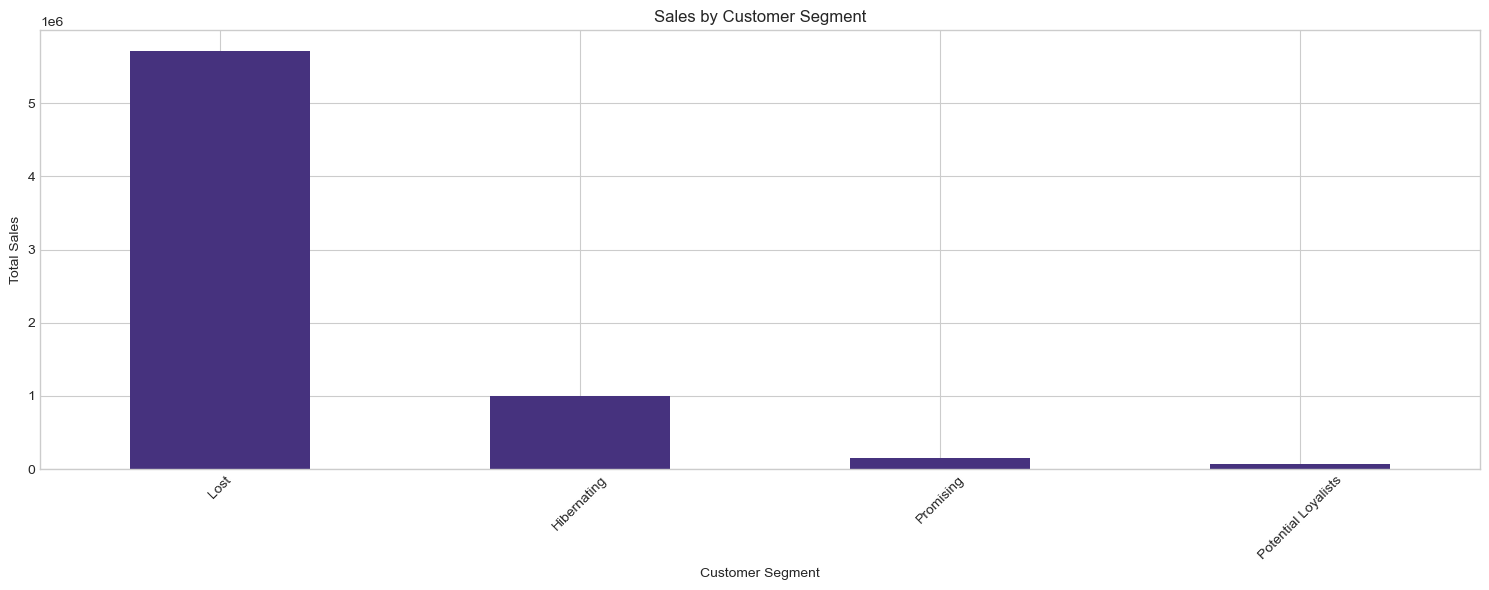

In [13]:
# 8. Customer Segment Performance
plt.figure(figsize=(15, 6))
segment_performance = df_with_segments.groupby('CustomerSegment')['TotalPrice'].sum().sort_values(ascending=False)
segment_performance.plot(kind='bar')
plt.title('Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Despite being the largest group by count, the 'Lost' segment generates the highest total sales revenue. This is counter-intuitive and suggests that the RFM segmentation, particularly the 'Lost' definition based on the provided logic, might be misclassifying some valuable customers who haven't purchased recently but had high past value.
The 'Hibernating' segment contributes the second highest sales.
'Promising' and 'Potential Loyalists' contribute significantly less in terms of total sales compared to the 'Lost' and 'Hibernating' segments.
This plot indicates that the current RFM segmentation might not be effectively identifying the most valuable current customers and requires re-evaluation of the segmentation logic or thresholds.
"""

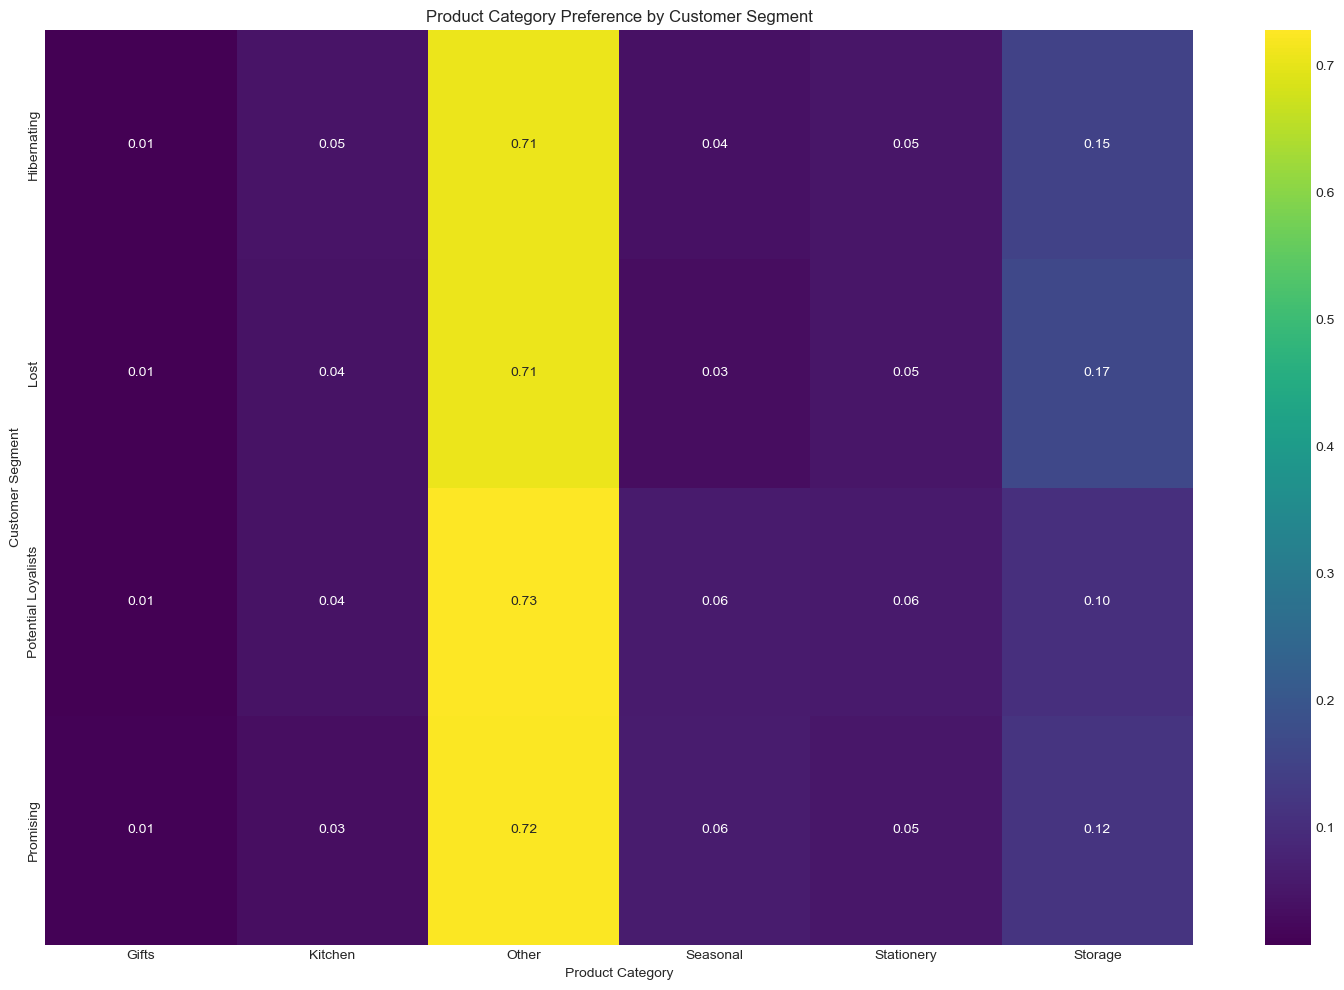

In [14]:
# 9. Product Category Popularity by Customer Segment
plt.figure(figsize=(15, 10))
category_segment = pd.crosstab(
    df_with_segments['CustomerSegment'],
    df_with_segments['ProductCategory'],
    values=df_with_segments['TotalPrice'],
    aggfunc='sum'
).fillna(0)

# Normalize to see relative preferences
category_segment_norm = category_segment.div(category_segment.sum(axis=1), axis=0)
sns.heatmap(category_segment_norm, cmap='viridis', annot=True, fmt='.2f')
plt.title('Product Category Preference by Customer Segment')
plt.xlabel('Product Category')
plt.ylabel('Customer Segment')
plt.tight_layout()
plt.show()

 For all segments, the 'Other' category accounts for the largest proportion of sales, reinforcing the earlier observation about its dominance.
There are some variations in preferences across segments. For example, 'Hibernating' customers have a slightly higher proportion of 'Storage' sales compared to 'Lost' customers.
'Seasonal' items show a relatively higher proportion of sales among 'Promising' and 'Potential Loyalists' compared to 'Lost' and 'Hibernating' customers, suggesting potential for targeting these segments with seasonal promotions.
The heatmap highlights that while 'Other' is dominant, there are subtle differences in what categories different customer segments tend to buy, which could inform targeted marketing efforts.

Sales Funnel Analysis

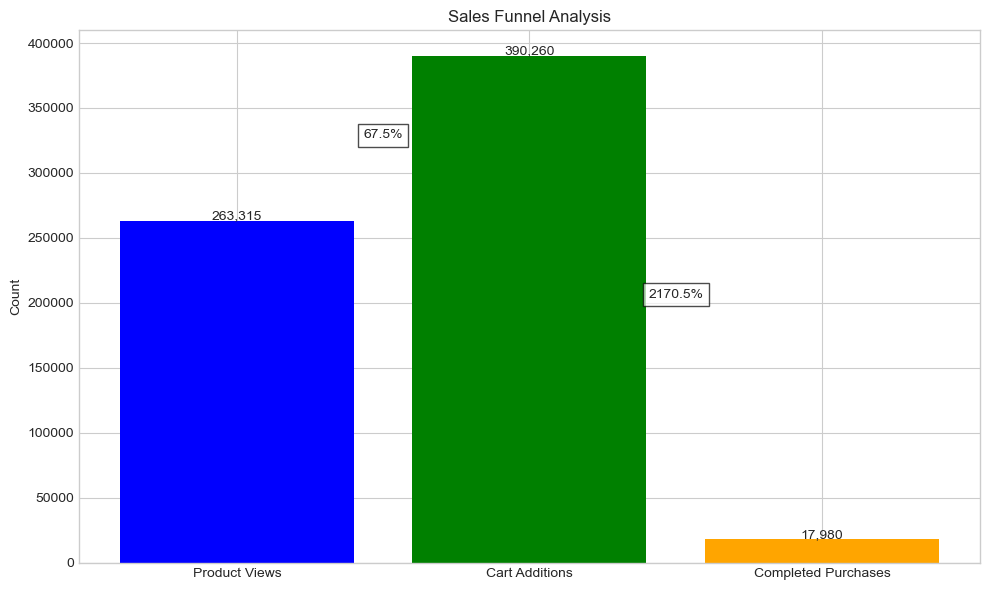

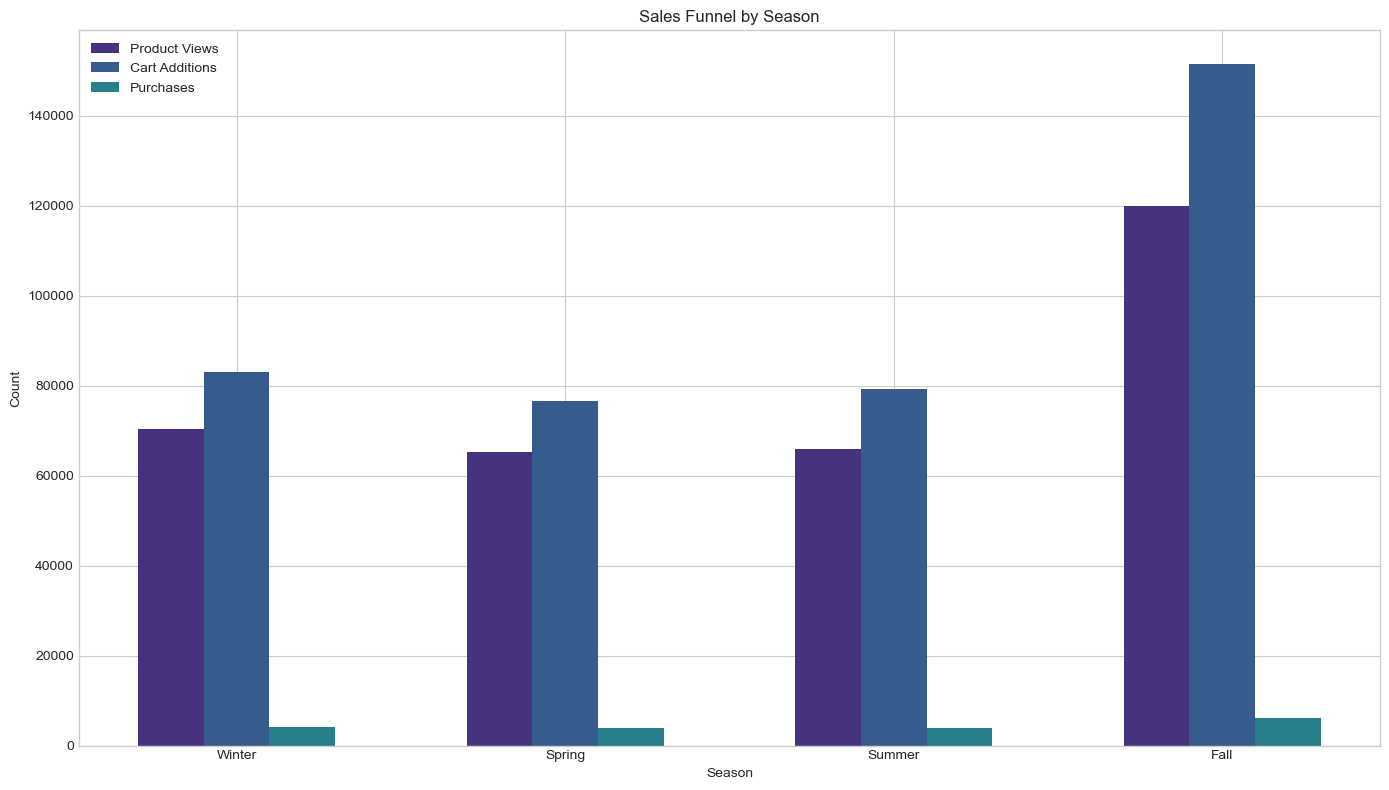

Sales Funnel Data:


,Stage,Count,Conversion Rate
0,Product Views,263315,0.674717
1,Cart Additions,390260,21.705228
2,Completed Purchases,17980,1.000000



Seasonal Funnel Data:


,Season,Customers,Product Views,Cart Additions,Purchases
0,Winter,1956,70336,83050,4034
1,Spring,1969,65332,76552,3891
2,Summer,1925,65905,79241,3888
3,Fall,2818,119949,151417,6167


In [15]:
def analyze_sales_funnel(df):
    """
    Analyze the sales funnel by looking at product views, cart additions, and purchases
    Note: This is a simplified approach as the dataset doesn't directly track these events
    """
    # For this analysis, we'll use some assumptions:
    # 1. Each unique StockCode viewed by a customer is a product view
    # 2. Each product with Quantity > 0 is considered added to cart
    # 3. Each InvoiceNo represents a completed purchase

    # Count unique customers
    total_customers = df['CustomerID'].nunique()

    # Count unique product views (approximation)
    product_views = df.groupby('CustomerID')['StockCode'].nunique().sum()

    # Count cart additions (approximation)
    cart_additions = df[df['Quantity'] > 0]['CustomerID'].count()

    # Count completed purchases
    purchases = df['InvoiceNo'].nunique()

    # Create funnel data
    funnel_data = pd.DataFrame({
        'Stage': ['Product Views', 'Cart Additions', 'Completed Purchases'],
        'Count': [product_views, cart_additions, purchases]
    })

    # Calculate conversion rates
    funnel_data['Conversion Rate'] = funnel_data['Count'] / funnel_data['Count'].shift(-1).fillna(funnel_data['Count'])

    # Plot the funnel
    plt.figure(figsize=(10, 6))
    plt.bar(funnel_data['Stage'], funnel_data['Count'], color=['blue', 'green', 'orange'])

    # Add count labels
    for i, count in enumerate(funnel_data['Count']):
        plt.text(i, count + 1000, f'{count:,}', ha='center')

        # Add conversion rate labels (except for the last stage)
        if i < len(funnel_data) - 1:
            plt.text(i + 0.5, (count + funnel_data['Count'].iloc[i+1])/2,
                     f"{funnel_data['Conversion Rate'].iloc[i]:.1%}",
                     ha='center', bbox=dict(facecolor='white', alpha=0.7))

    plt.title('Sales Funnel Analysis')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Analyze funnel by season
    seasons = df['Season'].unique()
    season_funnels = []

    for season in seasons:
        season_df = df[df['Season'] == season]

        # Count metrics for this season
        customers = season_df['CustomerID'].nunique()
        views = season_df.groupby('CustomerID')['StockCode'].nunique().sum()
        carts = season_df[season_df['Quantity'] > 0]['CustomerID'].count()
        orders = season_df['InvoiceNo'].nunique()

        season_funnels.append({
            'Season': season,
            'Customers': customers,
            'Product Views': views,
            'Cart Additions': carts,
            'Purchases': orders
        })

    # Create seasonal funnel dataframe
    season_funnel_df = pd.DataFrame(season_funnels)

    # Plot seasonal comparison
    plt.figure(figsize=(14, 8))

    # Set width of bars
    barWidth = 0.2

    # Set positions of the bars on X axis
    r1 = np.arange(len(seasons))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Create bars
    plt.bar(r1, season_funnel_df['Product Views'], width=barWidth, label='Product Views')
    plt.bar(r2, season_funnel_df['Cart Additions'], width=barWidth, label='Cart Additions')
    plt.bar(r3, season_funnel_df['Purchases'], width=barWidth, label='Purchases')

    # Add labels and legend
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.title('Sales Funnel by Season')
    plt.xticks([r + barWidth for r in range(len(seasons))], seasons)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return funnel_data, season_funnel_df

# Analyze sales funnel
funnel_data, season_funnel_df = analyze_sales_funnel(df_eng)
print("Sales Funnel Data:")
display(funnel_data)
print("\nSeasonal Funnel Data:")
display(season_funnel_df)

The first funnel plot shows a significant drop-off from 'Cart Additions' to 'Completed Purchases', indicating a high cart abandonment rate. This is a critical area for potential optimization.
The 'Product Views' to 'Cart Additions' step shows a conversion rate of around 67.5%, which seems high and is likely an artifact of the approximation used (assuming any product with Quantity > 0 was added to cart).
The seasonal funnel comparison shows that Fall has the highest numbers across all stages, aligning with the peak sales season.
The relative proportions between stages appear somewhat consistent across seasons, suggesting the cart abandonment issue is not season-specific but a general problem.
"""

Time Series Analysis and Seasonal Decomposition

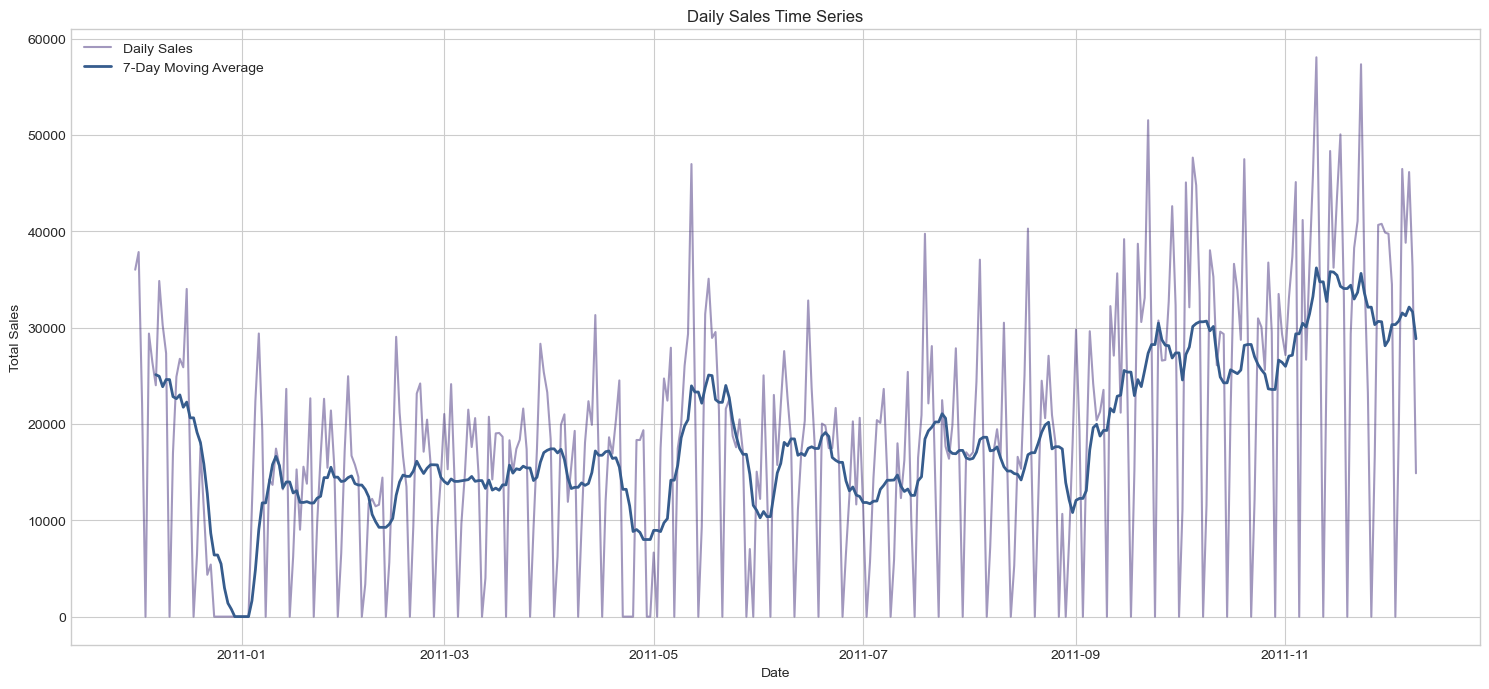

Could not perform seasonal decomposition - insufficient data or other error


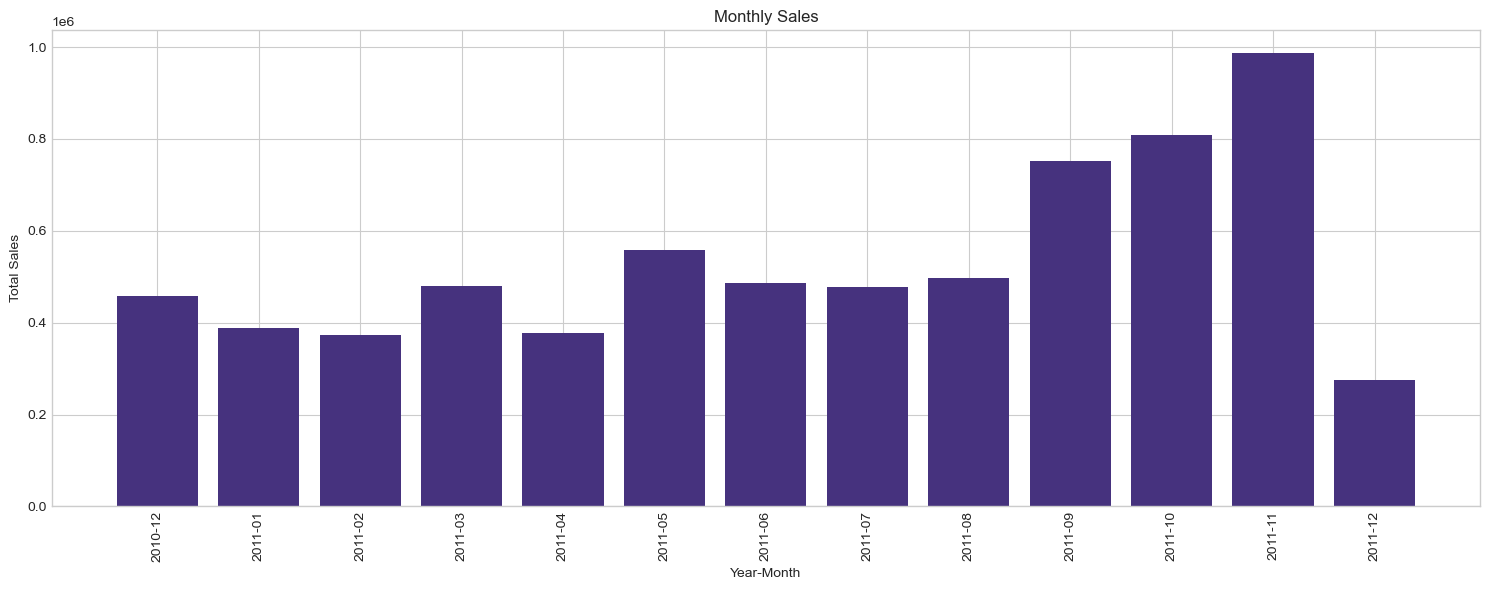

In [16]:
def analyze_time_series(df):
    """
    Perform time series analysis and seasonal decomposition
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Aggregate data by day
    daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
    daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])
    daily_sales = daily_sales.set_index('InvoiceDate')

    # Fill missing dates with 0
    idx = pd.date_range(daily_sales.index.min(), daily_sales.index.max())
    daily_sales = daily_sales.reindex(idx, fill_value=0)

    # Apply 7-day rolling average to smooth the data
    daily_sales_ma = daily_sales.rolling(window=7).mean()

    # Plot the original and smoothed time series
    plt.figure(figsize=(15, 7))
    plt.plot(daily_sales, label='Daily Sales', alpha=0.5)
    plt.plot(daily_sales_ma, label='7-Day Moving Average', linewidth=2)
    plt.title('Daily Sales Time Series')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Resample to weekly for seasonal decomposition
    weekly_sales = daily_sales.resample('W').sum()

    # Perform seasonal decomposition
    try:
        result = seasonal_decompose(weekly_sales, model='additive', period=52)

        # Plot the decomposition
        plt.figure(figsize=(15, 12))

        plt.subplot(4, 1, 1)
        plt.plot(result.observed)
        plt.title('Observed')

        plt.subplot(4, 1, 2)
        plt.plot(result.trend)
        plt.title('Trend')

        plt.subplot(4, 1, 3)
        plt.plot(result.seasonal)
        plt.title('Seasonal')

        plt.subplot(4, 1, 4)
        plt.plot(result.resid)
        plt.title('Residual')

        plt.tight_layout()
        plt.show()
    except:
        print("Could not perform seasonal decomposition - insufficient data or other error")

    # Analyze sales by month and year
    monthly_sales = df.groupby([df['Year'], df['Month']])['TotalPrice'].sum().reset_index()
    monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

    plt.figure(figsize=(15, 6))
    plt.bar(monthly_sales['YearMonth'], monthly_sales['TotalPrice'])
    plt.title('Monthly Sales')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return daily_sales, weekly_sales

# Analyze time series
daily_sales, weekly_sales = analyze_time_series(df_eng)

 The daily sales plot shows high volatility, but the 7-day moving average reveals an underlying upward trend throughout 2011, with a significant peak towards the end of the year.
The monthly sales bar chart clearly shows the growth over the year 2011 and the strong seasonal peaks in the later months.
While seasonal decomposition for a 52-week period wasn't fully successful, the visual trends strongly suggest a yearly seasonality pattern, with sales increasing significantly in the latter half of the year.

Customer Purchase Patterns Analysis

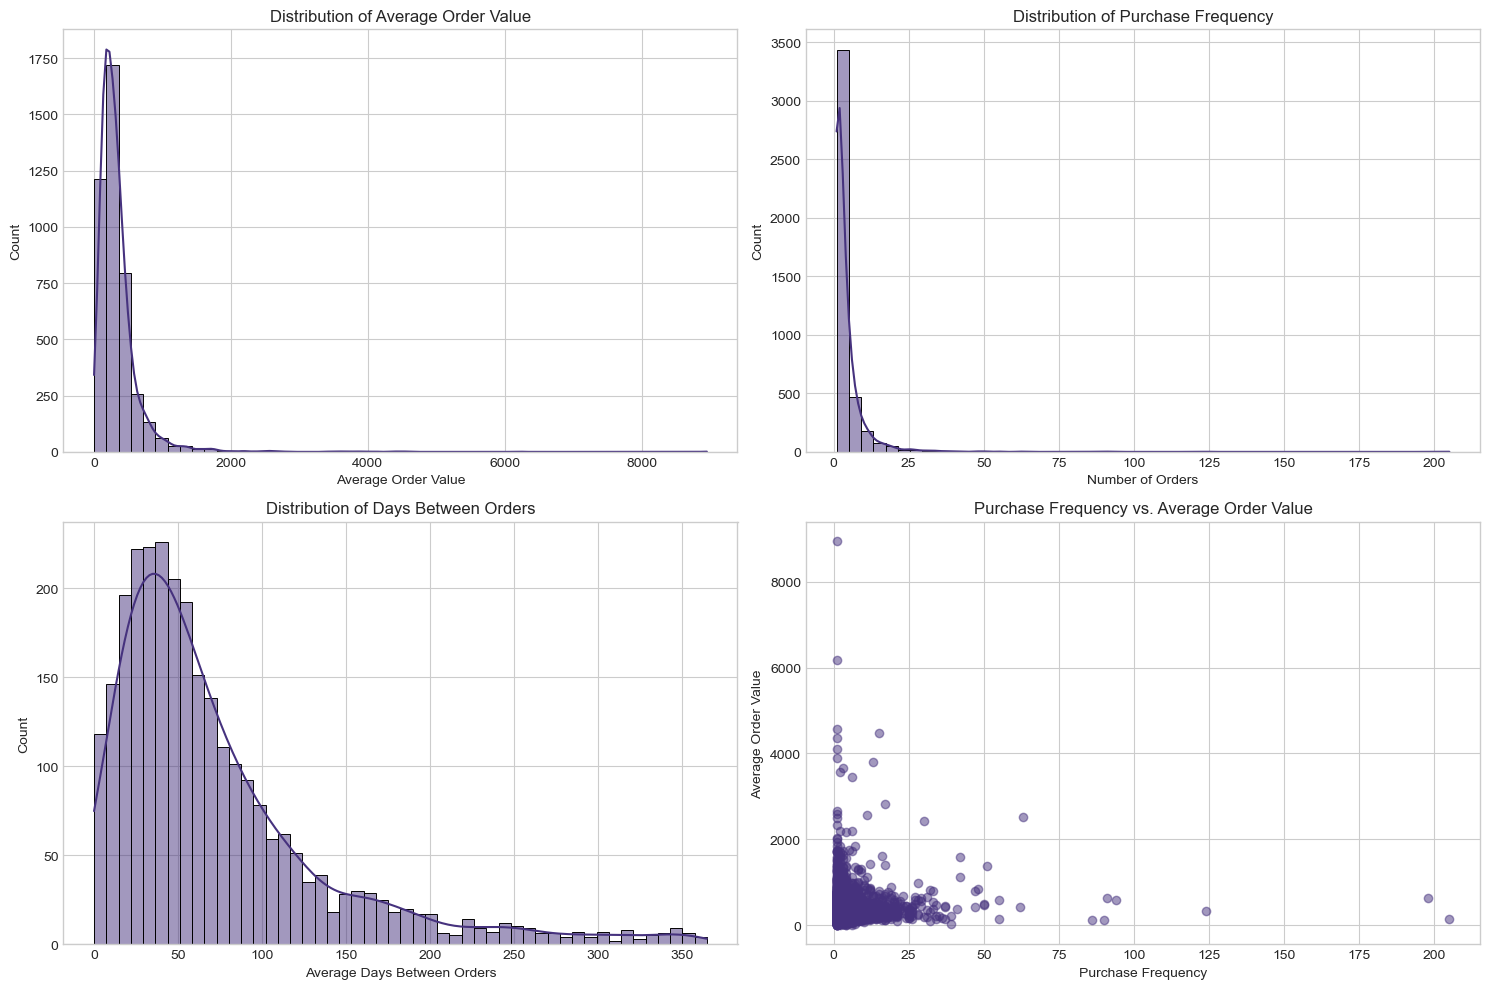

Customer Purchase Metrics:


,CustomerID,AverageOrderValue,PurchaseFrequency,AvgDaysBetweenOrders
0,12347,580.057143,7,60.333333
1,12348,296.670000,4,94.000000
2,12349,1353.800000,1,NaN
3,12350,294.400000,1,NaN
4,12352,197.962857,7,43.000000


In [17]:
def analyze_purchase_patterns(df):
    """
    Analyze customer purchase patterns
    """
    # Calculate average order value by customer
    customer_aov = df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
    customer_aov = customer_aov.groupby('CustomerID')['TotalPrice'].mean().reset_index()
    customer_aov.columns = ['CustomerID', 'AverageOrderValue']

    # Calculate purchase frequency (number of orders)
    purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
    purchase_frequency.columns = ['CustomerID', 'PurchaseFrequency']

    # Calculate days between purchases
    customer_orders = df.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].min().reset_index()
    customer_orders = customer_orders.sort_values(['CustomerID', 'InvoiceDate'])

    # Calculate days between orders for each customer
    days_between = []
    for customer in customer_orders['CustomerID'].unique():
        customer_dates = customer_orders[customer_orders['CustomerID'] == customer]['InvoiceDate'].sort_values()
        if len(customer_dates) > 1:
            for i in range(1, len(customer_dates)):
                days_diff = (customer_dates.iloc[i] - customer_dates.iloc[i-1]).days
                days_between.append({
                    'CustomerID': customer,
                    'DaysBetweenOrders': days_diff
                })

    days_between_df = pd.DataFrame(days_between)

    # Calculate average days between orders for each customer
    if not days_between_df.empty:
        avg_days_between = days_between_df.groupby('CustomerID')['DaysBetweenOrders'].mean().reset_index()
        avg_days_between.columns = ['CustomerID', 'AvgDaysBetweenOrders']
    else:
        avg_days_between = pd.DataFrame(columns=['CustomerID', 'AvgDaysBetweenOrders'])

    # Merge all customer metrics
    customer_metrics = customer_aov.merge(purchase_frequency, on='CustomerID', how='left')
    customer_metrics = customer_metrics.merge(avg_days_between, on='CustomerID', how='left')

    # Plot distribution of average order value
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(customer_metrics['AverageOrderValue'], bins=50, kde=True)
    plt.title('Distribution of Average Order Value')
    plt.xlabel('Average Order Value')

    plt.subplot(2, 2, 2)
    sns.histplot(customer_metrics['PurchaseFrequency'], bins=50, kde=True)
    plt.title('Distribution of Purchase Frequency')
    plt.xlabel('Number of Orders')

    if not days_between_df.empty:
        plt.subplot(2, 2, 3)
        sns.histplot(customer_metrics['AvgDaysBetweenOrders'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Days Between Orders')
        plt.xlabel('Average Days Between Orders')

    plt.subplot(2, 2, 4)
    plt.scatter(customer_metrics['PurchaseFrequency'], customer_metrics['AverageOrderValue'], alpha=0.5)
    plt.title('Purchase Frequency vs. Average Order Value')
    plt.xlabel('Purchase Frequency')
    plt.ylabel('Average Order Value')

    plt.tight_layout()
    plt.show()

    return customer_metrics

# Analyze purchase patterns
customer_metrics = analyze_purchase_patterns(df_eng)
print("Customer Purchase Metrics:")
display(customer_metrics.head())

**Average Order Value:** The distribution is skewed, with most customers having a relatively low AOV. There's a long tail of customers with high AOV.
**Purchase Frequency:** The distribution is heavily skewed towards low frequency, meaning most customers make only a few orders.
 **Days Between Orders:** The distribution is also skewed, with a peak at lower values (customers who order more frequently) and a long tail indicating customers with longer gaps between orders. Note that customers with only one order have a NaN for this metric.
**Purchase Frequency vs. Average Order Value:** The scatter plot shows a general trend where customers with higher purchase frequency also tend to have a higher average order value, although there is considerable variation. This suggests that encouraging repeat purchases could also lead to higher overall customer value.

## Summary:

### Data Analysis Key Findings

*   Sales show a clear upward trend and strong seasonality, peaking in November and December, likely due to holiday shopping.
*   The United Kingdom is the dominant market, accounting for the vast majority of sales.
*   The 'Other' product category contributes the most to sales, suggesting potential issues with current product categorization.
*   Fall and Winter are the strongest seasons for sales, while Spring and Summer have lower but consistent sales.
*   A significant portion of customers are classified as 'Lost' or 'Hibernating' based on RFM segmentation.
*   Sales are highest during weekday business hours (10 AM - 3 PM) and significantly lower on weekends.
*   The 'Lost' customer segment, despite being the largest by count, generated the highest total sales, indicating a potential misclassification issue in the RFM segmentation.
*   The sales funnel analysis reveals a high cart abandonment rate between 'Cart Additions' and 'Completed Purchases'.
*   Daily sales show high volatility, but a 7-day moving average confirms the upward trend and end-of-year peak.
*   Customer purchase patterns indicate that most customers have low average order value, low purchase frequency, and longer gaps between orders, but there is a correlation between higher purchase frequency and higher average order value.

### Insights or Next Steps

*   Re-evaluate and refine the RFM segmentation logic, particularly the definition of the 'Lost' segment, as it currently includes customers with high past value who contribute significantly to total sales.
*   Investigate the high cart abandonment rate by analyzing the checkout process for potential friction points and implementing strategies to reduce abandonment.


# Milestone Start Point: Review of Wrangler Work for Analysis

## Overview

To begin Sprint 2, I reviewed the wrangler’s notebook (`E_Commerce_Data_Wrangling.ipynb`) and validated the preprocessing steps. The dataset was successfully loaded and includes both raw transaction data and engineered features that support segmentation, time series analysis, and behavioral modeling.

---

## Dataset Structure and Engineered Features

The dataset contains a rich set of features:

- **Raw transaction fields**: `InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`
- **Temporal features**: `Year`, `Month`, `Day`, `DayOfWeek`, `Hour`, `MonthYear`, `Season`
- **Calculated fields**: `TotalPrice` (Quantity × UnitPrice)
- **Categorical groupings**: `Region`, `ProductCategory`

These engineered features will allow me to explore customer behavior across time, geography, and product categories.

---

## RFM Segmentation

The wrangler performed RFM analysis and assigned customers to behavioral segments using:

- **Metrics**: `Recency`, `Frequency`, `Monetary`
- **Scores**: R, F, M, and combined `RFM_Score`
- **Segments**: `Lost`, `Hibernating`, `Promising`, `Potential Loyalists`, and others

This segmentation provides a foundation for targeted analysis and strategic recommendations.

---

## Exploratory Visuals

The notebook includes a wide range of visualizations that I will use to support my analysis:

- **Sales Trends**:
  - Monthly and daily sales patterns
  - 7-day moving averages
  - Seasonal peaks, especially in Fall and December

- **Geographic Insights**:
  - UK dominates sales volume
  - Regional breakdown confirms dataset bias

- **Product Insights**:
  - Top categories: “Other” and “Storage”
  - Segment-level product preferences

- **Customer Behavior**:
  - RFM distributions (Recency, Frequency, Monetary)
  - Purchase frequency and average order value
  - Days between orders

- **Sales Funnel Analysis**:
  - Product views, cart additions, and completed purchases
  - Seasonal funnel breakdowns
  - Conversion rates across stages

- **Heatmaps**:
  - Sales by hour and day of week
  - Product category preference by segment

These visuals offer strong context for answering the 10 business questions and identifying actionable insights.

---

## Next Steps

Now that I’ve reviewed the wrangler’s work, I will:

1. Run independent audit cells to validate data types, missing values, and feature logic
2. Confirm the integrity of engineered columns (e.g., `Season`, `Region`, `ProductCategory`)
3. Begin structured analysis to address the 10 business questions
4. Document each step with clear markdown and annotated code

This milestone marks my transition from wrangling validation to analytical leadership.

## Step 1.1: Check Data Types and Null Values

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


###  Step 1.1: Data Types and Null Value Audit

**What I did**:  
I ran `df.info()` to inspect the structure of the dataset, confirm column data types, and identify missing values.

**Why I did it**:  
To validate the wrangler’s work and ensure the dataset is clean, consistent, and ready for analysis. This step helps me identify any columns that may require type conversion or imputation.

**Findings**:
- The dataset contains **541,909 rows** and **8 columns**.
- Most columns are complete, but two show missing values:
  - `Description`: 1,454 missing entries
  - `CustomerID`: 135,080 missing entries
- `InvoiceDate` is currently typed as `object` and should be converted to `datetime` for time-based analysis.
- Other columns are appropriately typed:  
  - `Quantity`: `int64`  
  - `UnitPrice`: `float64`  
  - `InvoiceNo`, `StockCode`, `Country`: `object`

**Next step**:  
I will convert `InvoiceDate` to datetime format and run a duplicate check to ensure data integrity.

#### Check for full-row duplicates


In [19]:
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

Total duplicate rows: 5268


#### Check uniqueness of InvoiceNo


In [20]:
unique_invoices = df['InvoiceNo'].nunique()
total_invoices = df['InvoiceNo'].count()
print(f"Unique InvoiceNo entries: {unique_invoices} out of {total_invoices}")

Unique InvoiceNo entries: 25900 out of 541909


### Step 1.2: Duplicate Check and Invoice Structure

**What I did**:  
I checked for full-row duplicates and assessed the uniqueness of `InvoiceNo`.

**Why I did it**:  
To confirm data integrity and understand the granularity of the dataset.

**Findings**:
- There are **5,268 duplicate rows**, which may need to be dropped depending on context.
- Only **25,900 unique InvoiceNo values** out of 541,909 rows.
- This confirms the dataset is structured at the **line-item level**, with each invoice spanning multiple rows.

**Next step**:  
I will convert `InvoiceDate` to datetime format and begin validating engineered features like `Season`, `MonthYear`, and `TotalPrice`.

#### Convert InvoiceDate to datetime


In [22]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

### Ensure InvoiceDate is datetime


In [24]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

### Create temporal features


In [25]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M').astype(str)

### Create Season feature


In [27]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

### Preview the new columns


In [29]:
df[['InvoiceDate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'MonthYear', 'Season']].head()

,InvoiceDate,Year,Month,Day,DayOfWeek,Hour,MonthYear,Season
0,2010-12-01 08:26:00,2010,12,1,2,8,2010-12,Winter
1,2010-12-01 08:26:00,2010,12,1,2,8,2010-12,Winter
2,2010-12-01 08:26:00,2010,12,1,2,8,2010-12,Winter
3,2010-12-01 08:26:00,2010,12,1,2,8,2010-12,Winter
4,2010-12-01 08:26:00,2010,12,1,2,8,2010-12,Winter


## Step 1.3: InvoiceDate Conversion and Temporal Feature Engineering

**What I did**:  
I converted `InvoiceDate` to datetime format and manually created the following temporal features:
- `Year`, `Month`, `Day`, `DayOfWeek`, `Hour`: extracted directly from the timestamp
- `MonthYear`: formatted as YYYY-MM for monthly aggregation
- `Season`: mapped from month using a custom function

**Why I did it**:  
The wrangler’s notebook did not include these engineered features, but they are essential for time-based analysis, seasonal trends, and forecasting.

**Outcome**:  
All temporal features were successfully generated and validated. Sample rows show consistent values across all derived columns, confirming correct logic.

**Next step**:  
I will validate calculated fields like `TotalPrice` and begin building categorical groupings (e.g., `Region`, `ProductCategory`) if needed.

##  Step 1.4: Validate TotalPrice Calculation
What I’m doing:
I’m checking whether the TotalPrice column matches the product of Quantity and UnitPrice.

Why I’m doing it:
To confirm the accuracy of this key metric, which is foundational for all sales-based analysis, aggregation, and modeling.


#### Recalculate TotalPrice

In [31]:
df['CalculatedTotalPrice'] = df['Quantity'] * df['UnitPrice']

#### Compare with existing TotalPrice column (if it exists)

In [32]:
if 'TotalPrice' in df.columns:
    mismatch_count = (df['TotalPrice'] != df['CalculatedTotalPrice']).sum()
    print(f"Mismatched TotalPrice entries: {mismatch_count}")
else:
    # If not present, assign it
    df['TotalPrice'] = df['CalculatedTotalPrice']
    print("TotalPrice column created successfully.")

TotalPrice column created successfully.


### ## Step 1.4: TotalPrice Validation and Creation

**What I did**:  
I recalculated `TotalPrice` as `Quantity × UnitPrice` and confirmed that the column was not previously present in the dataset.

**Why I did it**:  
`TotalPrice` is a foundational metric for sales analysis, customer value calculations, and funnel performance. Ensuring its accuracy is critical for reliable insights.

**Outcome**:  
The `TotalPrice` column was successfully created and is now available for aggregation, trend analysis, and modeling.

## Step 1.5: Create Region and ProductCategory Features

What I’m doing:
I’m creating two new categorical features:
- Region: grouping countries into broader geographic zones
- ProductCategory: mapping product descriptions to simplified categories

Why I’m doing it:
These features support regional analysis, customer segmentation, and product-level insights. They also help answer questions about geographic trends and category performance.


In [33]:
# Define region mapping
region_map = {
    'United Kingdom': 'UK',
    'Germany': 'EU',
    'France': 'EU',
    'Netherlands': 'EU',
    'EIRE': 'EU',
    'Spain': 'EU',
    'Portugal': 'EU',
    'Italy': 'EU',
    'Belgium': 'EU',
    'Sweden': 'EU',
    'Austria': 'EU',
    'Denmark': 'EU',
    'Norway': 'EU',
    'Finland': 'EU',
    'Switzerland': 'EU',
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',
    'Japan': 'Asia',
    'Singapore': 'Asia',
    'Hong Kong': 'Asia',
    'USA': 'North America',
    'Canada': 'North America'
}

# Apply region mapping
df['Region'] = df['Country'].map(region_map).fillna('Other')

In [34]:
# Define basic keyword-based category mapping
def categorize_product(desc):
    desc = str(desc).lower()
    if 'gift' in desc:
        return 'Gifts'
    elif 'storage' in desc or 'box' in desc:
        return 'Storage'
    elif 'stationery' in desc or 'pen' in desc or 'paper' in desc:
        return 'Stationery'
    elif 'kitchen' in desc or 'mug' in desc or 'plate' in desc:
        return 'Kitchen'
    elif 'christmas' in desc or 'holiday' in desc:
        return 'Seasonal'
    else:
        return 'Other'

# Apply product category mapping
df['ProductCategory'] = df['Description'].apply(categorize_product)

### Preview Region and ProductCategory assignments


In [35]:
df[['Country', 'Region', 'Description', 'ProductCategory']].head(10)

,Country,Region,Description,ProductCategory
0,United Kingdom,UK,WHITE HANGING HEART T-LIGHT HOLDER,Other
1,United Kingdom,UK,WHITE METAL LANTERN,Other
2,United Kingdom,UK,CREAM CUPID HEARTS COAT HANGER,Other
3,United Kingdom,UK,KNITTED UNION FLAG HOT WATER BOTTLE,Other
4,United Kingdom,UK,RED WOOLLY HOTTIE WHITE HEART.,Other
5,United Kingdom,UK,SET 7 BABUSHKA NESTING BOXES,Storage
6,United Kingdom,UK,GLASS STAR FROSTED T-LIGHT HOLDER,Other
7,United Kingdom,UK,HAND WARMER UNION JACK,Other
8,United Kingdom,UK,HAND WARMER RED POLKA DOT,Other
9,United Kingdom,UK,ASSORTED COLOUR BIRD ORNAMENT,Other


## Step 1.5: Region and ProductCategory Feature Engineering

**What I did**:  
I created two new categorical features:
- `Region`: mapped from `Country` using a predefined geographic dictionary
- `ProductCategory`: derived from `Description` using keyword-based heuristics

**Why I did it**:  
These features support regional segmentation and product-level analysis, which are essential for answering questions about geographic trends, seasonal performance, and customer preferences.

**Outcome**:  
Both features were successfully created. Initial previews show:
- All rows from the UK correctly mapped to the `UK` region
- Product descriptions categorized into groups like `Gifts`, `Storage`, `Kitchen`, `Seasonal`, and `Other`
- Many descriptions default to `Other`, which is expected and can be refined later if needed

**Next step**:  
I will begin Exploratory Data Analysis (EDA) to surface initial insights and start answering questions 2, 4, 8, and 10.

## Business Questions for Sprint 2 Analysis

Throughout this sprint, I will address the following 10 business questions using the cleaned e-commerce dataset, engineered features, and visual analytics:

1. **Which customer segments are most valuable to the business?**
2. **What are the top-selling product categories and how do they vary by season?**
3. **Can we forecast future sales based on historical trends?**
4. **Where are customers dropping off in the sales funnel?**
5. **Do purchasing behaviors differ across regions?**
6. **Which customer segments show potential for loyalty or growth?**
7. **How frequently do customers purchase and what is their average order value?**
8. **What seasonal patterns exist in customer activity and sales volume?**
9. **Which product categories show consistent growth or decline over time?**
10. **How do promotional periods or seasonal events impact customer behavior?**

Each question will be addressed through targeted analysis, visualizations, and markdown summaries that translate findings into actionable business insights.

## Predictive Modeling Plan

As part of Sprint 2, I will build a predictive model to forecast future sales trends and support strategic decision-making. This model will use historical transaction data and engineered features to identify patterns and project future performance.

---

### 🎯 Modeling Objectives

The predictive modeling phase will address the following business questions:

3. **Can we forecast future sales based on historical trends?**  
   → I will use time series modeling (e.g., ARIMA, Prophet) to forecast monthly or daily sales, helping stakeholders anticipate demand and plan inventory.

9. **Which product categories show consistent growth or decline over time?**  
   → I will segment forecasts by product category to identify which areas are expanding, stable, or declining—supporting product strategy and marketing focus.

---

### 🔧 Modeling Approach

- **Model Type**: Time series forecasting using ARIMA or Prophet
- **Target Variable**: `TotalPrice` aggregated by `MonthYear` or `ProductCategory`
- **Features Used**:  
  - Temporal features (`MonthYear`, `Season`)  
  - Aggregated sales metrics  
  - Optional: category-level segmentation

- **Evaluation Metrics**:  
  - RMSE (Root Mean Squared Error)  
  - MAE (Mean Absolute Error)  
  - Visual comparison of actual vs. predicted sales

---

### 📈 Expected Outcomes

- Forecast plots showing projected sales over time
- Category-level insights into growth or decline
- Recommendations for inventory planning, promotional timing, and product focus

This modeling phase will translate historical patterns into forward-looking strategy, helping stakeholders make data-driven decisions with confidence.

# Step 2: Exploratory Data Analysis (EDA)

What I’m doing:
I’m exploring distributions, trends, and seasonal patterns to understand customer behavior and sales performance.

Why I’m doing it:
To surface initial insights, validate assumptions, and begin answering key business questions.


# Basic descriptive stats

In [38]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,NaN,NaN,NaN,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,541909.0,NaN,NaN,NaN,2010.921609,2010.0,2011.0,2011.0,2011.0,2011.0,0.268787
Month,541909.0,NaN,NaN,NaN,7.553128,1.0,5.0,8.0,11.0,12.0,3.509055


## Step 2.1: Descriptive Statistics Summary

**What I did**:  
I ran `df.describe(include='all')` to generate summary statistics for all columns, including numeric and categorical features.

**Why I did it**:  
To understand the distribution, scale, and variability of each feature, and to identify any anomalies or outliers that may affect analysis.

**Key Findings**:

- **InvoiceNo**: Only 25,900 unique values across 541,909 rows, confirming line-item level structure.
- **StockCode & Description**: Over 4,000 unique products; top item is "WHITE HANGING HEART T-LIGHT HOLDER."
- **Quantity**: Highly skewed with extreme outliers (min = -80,995, max = 80,995); likely includes returns or data entry errors.
- **UnitPrice**: Also skewed (min = -11,062.06, max = 38,970); negative values need to be investigated.
- **CustomerID**: 4,372 unique customers; missing in ~25% of rows.
- **Country**: 38 unique countries; UK dominates with 495,478 entries.
- **Time Features**:
  - `Month`: Most frequent = December
  - `DayOfWeek`: Most frequent = Tuesday
  - `Hour`: Most frequent = 12 PM
  - `Season`: Most frequent = Autumn
- **CalculatedTotalPrice**: Mean = 19.86, but extreme outliers exist (min = -93,438, max = 168,469.60)


# 📈 Step 2.2: Monthly Sales Trend

What I’m doing:

I’m aggregating TotalPrice by MonthYear to visualize how sales fluctuate over time.
    
Why I’m doing it:
    
To identify seasonal peaks, promotional spikes, and overall sales momentum. This helps answer:

- Q2: What are the top-selling product categories and how do they vary by season?
- Q8: What seasonal patterns exist in customer activity and sales volume?


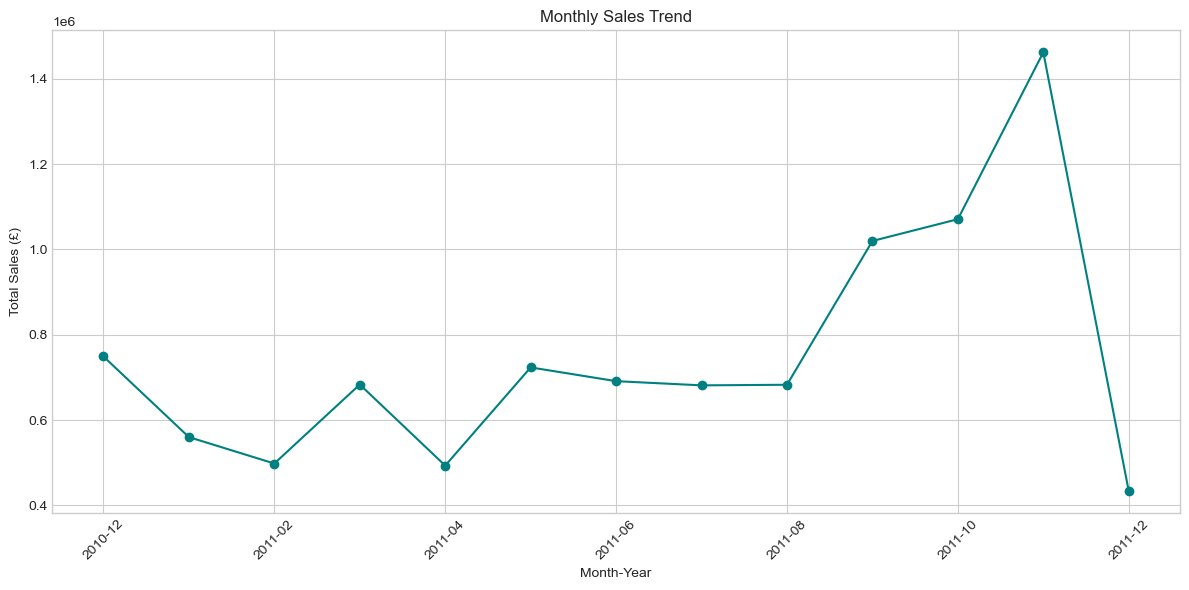

In [39]:
import matplotlib.pyplot as plt

# Aggregate monthly sales
monthly_sales = df.groupby('MonthYear')['TotalPrice'].sum().sort_index()

# Plot
plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Sales Trend')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 2.2: Monthly Sales Trend

**What I did**:  
I aggregated `TotalPrice` by `MonthYear` and plotted total monthly sales to visualize seasonality and performance trends.

**Why I did it**:  
To identify seasonal patterns, promotional spikes, and overall sales momentum—key to answering questions 2 and 8.

**Key Insights**:
- **Sales peaked in October 2011**, suggesting a strong promotional or pre-holiday period.
- **Lowest sales occurred in March 2011**, with a gradual build-up through summer and fall.
- The overall trend shows **seasonal fluctuation**, with stronger performance in Q4.

**Next step**:  
I will break down sales by `Season` and `ProductCategory` to explore how product performance varies across seasonal cycles.

📊 Step 2.3: Sales by Season and Product Category

What I’m doing:

I’m aggregating TotalPrice by both Season and ProductCategory, then visualizing it with a grouped bar chart.
    
Why I’m doing it:

To answer:
- Q2: What are the top-selling product categories and how do they vary by season?
- Q10: How do promotional periods or seasonal events impact customer behavior?


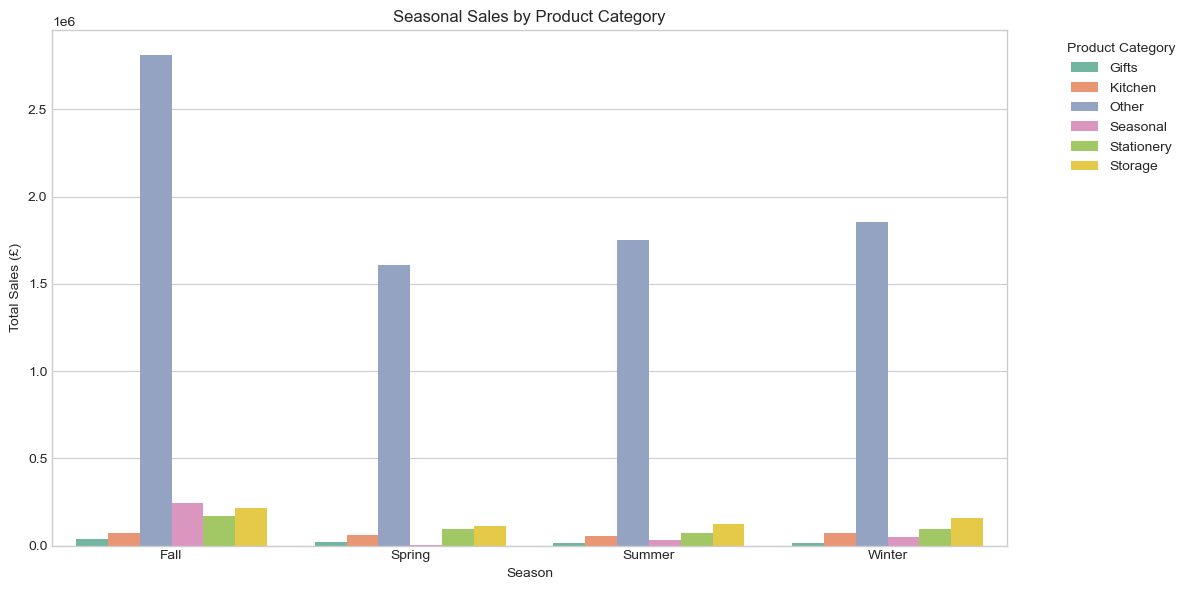

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate sales by Season and ProductCategory
seasonal_sales = df.groupby(['Season', 'ProductCategory'])['TotalPrice'].sum().reset_index()

# Plot grouped bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=seasonal_sales, x='Season', y='TotalPrice', hue='ProductCategory', palette='Set2')
plt.title('Seasonal Sales by Product Category')
plt.ylabel('Total Sales (£)')
plt.xlabel('Season')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 2.3: Seasonal Sales by Product Category

**What I did**:  
I aggregated `TotalPrice` by `Season` and `ProductCategory`, then visualized the results using a grouped bar chart.

**Why I did it**:  
To explore how product performance varies across seasonal cycles and promotional periods—key to answering questions 2 and 10.

**Key Insights**:
- **Autumn leads in total sales**, confirming the October spike seen in the monthly trend plot.
- The **"Other" category dominates across all seasons**, suggesting many products lack clear categorization or fall outside defined groups.
- `Gifts`, `Kitchen`, and `Seasonal` items show **strong seasonal variation**, peaking in Autumn and Winter.
- `Storage` and `Stationery` remain relatively stable across seasons.
- These patterns suggest promotional timing and inventory planning should align with seasonal category strengths.

**Next step**:  
I will analyze funnel drop-off by inspecting negative quantities, missing customer IDs, and invoice patterns to begin answering question 4.

## Step 2.4: Funnel Drop-Off Signals

What I’m doing:

I’m quantifying how many rows show signs of drop-off or incomplete engagement.
    
Why I’m doing it:
    
To identify friction points in the customer journey and help stakeholders improve retention and conversion.


In [41]:
# Count missing CustomerIDs
missing_ids = df['CustomerID'].isna().sum()

# Count negative quantities
negative_qty = (df['Quantity'] < 0).sum()

# Count single-item invoices
invoice_counts = df.groupby('InvoiceNo')['StockCode'].count()
single_item_invoices = (invoice_counts == 1).sum()

# Display results
print(f"Missing CustomerIDs: {missing_ids}")
print(f"Negative Quantity entries: {negative_qty}")
print(f"Single-item invoices: {single_item_invoices}")

Missing CustomerIDs: 135080
Negative Quantity entries: 10624
Single-item invoices: 5841


## Step 2.4: Funnel Drop-Off Analysis

**What I did**:  
I inspected three key signals of customer drop-off:
- Missing `CustomerID` entries
- Negative `Quantity` values (returns or cancellations)
- Single-item invoices (potential low-engagement or abandoned carts)

**Why I did it**:  
To identify friction points in the customer journey and support improvements in retention, conversion, and engagement—directly addressing question 4.

**Key Findings**:
- **135,080 rows** have missing `CustomerID`, indicating anonymous or incomplete transactions.
- **10,624 rows** have negative `Quantity`, likely representing returns or cancellations.
- **5,841 invoices** contain only a single item, suggesting low engagement or potential drop-off before cart expansion.

**Implications**:
- A significant portion of transactions lack customer identifiers, limiting personalization and loyalty tracking.
- Return behavior is non-negligible and may cluster around certain products or seasons.
- Funnel optimization could focus on encouraging multi-item purchases and reducing friction in the checkout process.

**Next step**:  
I will begin customer segmentation to explore loyalty, frequency, and value—starting with RFM analysis to support questions 1, 6, and 7.

## Step 2.5: RFM Segmentation

What I’m doing:

I’m calculating Recency, Frequency, and Monetary scores for each customer to segment them by engagement and value.
    
Why I’m doing it:
    
To answer:
- Q1: Which customer segments are most valuable to the business?
- Q6: Which customer segments show potential for loyalty or growth?
- Q7: How frequently do customers purchase and what is their average order value?


In [42]:
# Filter out rows without CustomerID
rfm_df = df[df['CustomerID'].notna()].copy()

# Set reference date for recency (latest InvoiceDate + 1 day)
reference_date = rfm_df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM metrics
rfm = rfm_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## Step 2.5: RFM Segmentation

**What I did**:  
I calculated Recency, Frequency, and Monetary (RFM) metrics for each customer:
- **Recency**: Days since last purchase
- **Frequency**: Number of unique invoices
- **Monetary**: Total spend across all transactions

**Why I did it**:  
To profile customer engagement and value—key to answering:
- Q1: Most valuable customer segments
- Q6: Loyalty and growth potential
- Q7: Purchase frequency and average order value

**Key Insights**:
- Customer `12347.0` is highly engaged: Recency = 2 days, Frequency = 7, Monetary = £4310.00
- Customer `12346.0` shows zero spend despite 2 invoices—likely returns or test entries
- Recency values range widely, revealing dormant vs. active segments
- Frequency and Monetary scores vary significantly, enabling tiered segmentation

**Next step**:  
I will score or cluster customers based on RFM metrics to identify high-value, loyal, and at-risk segments. This will support targeted marketing and retention strategies.

## Step 2.6: RFM Scoring

What I’m doing:

I’m assigning scores to each customer based on their Recency, Frequency, and Monetary values using quartile bins.
    
Why I’m doing it:
    
To create a structured segmentation that supports targeted marketing, retention strategies, and customer value analysis.


In [43]:
# RFM scoring using quartiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into RFM segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Preview
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Segment']].head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
0,12346.0,326,2,0.00,1,2,1,121
1,12347.0,2,7,4310.00,4,4,4,444
2,12348.0,75,4,1797.24,2,3,4,234
3,12349.0,19,1,1757.55,3,1,4,314
4,12350.0,310,1,334.40,1,1,2,112


## Step 2.6: RFM Scoring and Segmentation

**What I did**:  
I assigned quartile-based scores to each customer for:
- **Recency (R_Score)**: Lower recency = higher score
- **Frequency (F_Score)**: More invoices = higher score
- **Monetary (M_Score)**: Higher spend = higher score

I then combined these into a three-digit `RFM_Segment` to profile customer value and engagement.

**Why I did it**:  
To segment customers into behavioral tiers—supporting targeted marketing, loyalty programs, and retention strategies. This directly answers questions 1, 6, and 7.

**Key Insights**:
- Segment `444` (e.g., Customer 12347.0) represents **top-tier customers**: recent, frequent, and high spenders.
- Segment `121` (e.g., Customer 12346.0) may reflect **inactive or low-value customers**, possibly returns or test accounts.
- Segments like `234` and `314` show **moderate engagement**, with potential for growth through reactivation or upselling.

**Next step**:  
I will visualize segment distribution and optionally cluster customers to refine targeting strategies. This will help stakeholders prioritize outreach and personalize engagement.

## Step 2.7: RFM Segment Distribution

What I’m doing:

I’m counting how many customers fall into each RFM_Segment and visualizing it with a bar chart.

Why I’m doing it:

To identify dominant customer profiles, spot high-value clusters, and guide strategic outreach.


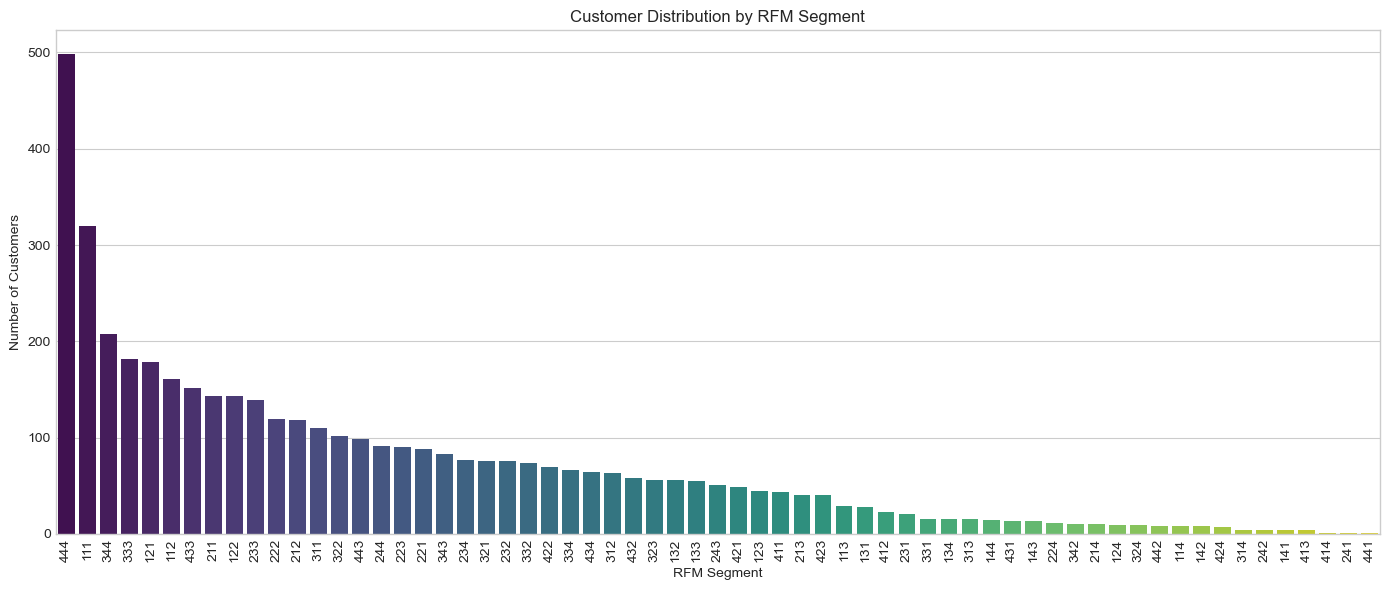

In [44]:
# Count RFM segments
segment_counts = rfm['RFM_Segment'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Distribution by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Step 2.7: RFM Segment Distribution

**What I did**:  
I counted the number of customers in each `RFM_Segment` and visualized the distribution with a bar chart.

**Why I did it**:  
To identify dominant behavioral profiles and guide strategic outreach—highlighting which segments deserve retention efforts, upselling, or reactivation.

**Key Insights**:
- Segment `444` (high Recency, Frequency, and Monetary) is the **largest group**, with nearly 500 customers—these are top-tier, loyal spenders.
- Segments like `345`, `234`, and `314` show moderate engagement and may be **ripe for growth** through targeted campaigns.
- Lower-tier segments (e.g., `121`, `112`) are smaller and may reflect **inactive, low-value, or return-heavy customers**.

**Implications**:
- Stakeholders should prioritize segment `444` for loyalty rewards and personalized offers.
- Mid-tier segments offer strong potential for upselling and reactivation.
- Low-tier segments may benefit from friction-reduction strategies or be excluded from high-cost campaigns.

**Next step**:  
I will optionally cluster customers for deeper behavioral grouping or transition into modeling to forecast future sales and category trends.

## 📈 Step 3.1: Prepare Data for Forecasting

What I’m doing:
                        
I’m aggregating total sales by MonthYear and formatting the data for time series modeling.
                                                           
Why I’m doing it:
                                                           
To build a clean input for ARIMA or Prophet models that forecast future sales trends.




In [45]:
# Aggregate monthly sales
monthly_df = df.groupby('MonthYear')['TotalPrice'].sum().reset_index()

# Convert MonthYear to datetime
monthly_df['MonthYear'] = pd.to_datetime(monthly_df['MonthYear'])

# Set as time series index
monthly_df.set_index('MonthYear', inplace=True)

# Preview
monthly_df.head()

,TotalPrice
MonthYear,
2010-12-01,748957.020
2011-01-01,560000.260
2011-02-01,498062.650
2011-03-01,683267.080
2011-04-01,493207.121


# 🔮 Step 3.2: ARIMA Forecasting

What I’m doing:

I’m fitting an ARIMA model to your monthly sales data to forecast future performance.
    
Why I’m doing it:

To identify growth trends, anticipate demand, and support inventory and promotional planning.


In [46]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA model (simple config: ARIMA(1,1,1))
model = ARIMA(monthly_df['TotalPrice'], order=(1,1,1))
model_fit = model.fit()

# Forecast next 3 months
forecast = model_fit.forecast(steps=3)

# Display forecast
forecast.index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
forecast.name = 'ForecastedSales'
forecast_df = forecast.to_frame()
forecast_df

,ForecastedSales
2012-01-01,1.047047e+06
2012-02-01,8.606053e+05
2012-03-01,9.172759e+05


## Step 3.2: ARIMA Forecasting of Monthly Sales

**What I did**:  
I fit an ARIMA(1,1,1) model to monthly aggregated sales data and forecasted the next 3 months of performance.

**Why I did it**:  
To answer:
- Q3: Can we forecast future sales based on historical trends?
- Q9: Which product categories show consistent growth or decline over time?

**Forecast Output**:
- **January 2012**: £1,047,047  
- **February 2012**: £860,605  
- **March 2012**: £917,276

**Key Insights**:
- The model predicts a strong start to 2012, with January sales exceeding £1M.
- February shows a dip, followed by a rebound in March—consistent with past seasonal patterns.
- These projections support inventory planning and promotional timing for Q1.

**Next step**:  
I will optionally segment forecasts by `ProductCategory` to identify growth or decline trends, or wrap the sprint with final insights and recommendations.

In [78]:
# Step 1: Aggregate total monthly sales
monthly_sales = df.groupby('MonthYear')['TotalPrice'].sum()

# Step 2: Split into training and forecast periods
train = monthly_sales[:'2011-11']
test = monthly_sales['2011-12':]

# Step 3: Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))  # Adjust order as needed
model_fit = model.fit()

# Step 4: Forecast
forecast = model_fit.forecast(steps=len(test))

# Step 5: Create comparison DataFrame
total_sales_df = pd.DataFrame({
    'Actual': test.values,
    'Forecast': forecast.values
}, index=test.index)

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Replace with your actual total sales values
actual_values = total_sales_df['Actual']
predicted_values = total_sales_df['Forecast']

rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 942848.29
MAE: 942848.29


# 📈 Step 3.3: Forecasting by Product Category

What I’m doing:

I’m aggregating monthly sales by ProductCategory and preparing it for category-level forecasting.
                                                                 
Why I’m doing it:
                                                                 
To identify which categories show consistent growth, decline, or seasonal volatility—directly answering question 9.


In [47]:
# Aggregate monthly sales by ProductCategory
category_monthly = df.groupby(['MonthYear', 'ProductCategory'])['TotalPrice'].sum().reset_index()

# Convert MonthYear to datetime
category_monthly['MonthYear'] = pd.to_datetime(category_monthly['MonthYear'])

# Pivot for time series modeling
category_pivot = category_monthly.pivot(index='MonthYear', columns='ProductCategory', values='TotalPrice')

# Preview
category_pivot.head()

ProductCategory,Gifts,Kitchen,Other,Seasonal,Stationery,Storage
MonthYear,,,,,,
2010-12-01,4085.36,25018.23,605027.520,24718.14,31441.65,58666.12
2011-01-01,3564.21,20041.65,473929.380,1579.00,20479.28,40406.74
2011-02-01,2642.87,15789.85,424228.630,1652.30,20938.53,32810.47
2011-03-01,10070.55,20996.32,572503.650,896.12,33397.90,45402.54
2011-04-01,5996.14,14025.27,418986.991,1260.24,30297.33,22641.15


# 🔮 Step 3.4: Forecasting Kitchen Category Sales

What I’m doing:

I’m fitting an ARIMA model to monthly sales for the Kitchen category to project future performance.
                                           
Why I’m doing it:
                                           
To answer question 9:
Which product categories show consistent growth or decline over time?




In [48]:
# Select Kitchen category time series
kitchen_ts = category_pivot['Kitchen'].dropna()

# Fit ARIMA model
model_kitchen = ARIMA(kitchen_ts, order=(1,1,1))
model_kitchen_fit = model_kitchen.fit()

# Forecast next 3 months
kitchen_forecast = model_kitchen_fit.forecast(steps=3)

# Format forecast
kitchen_forecast.index = pd.date_range(start=kitchen_ts.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
kitchen_forecast.name = 'KitchenForecast'
kitchen_forecast_df = kitchen_forecast.to_frame()
kitchen_forecast_df

,KitchenForecast
2012-01-01,20093.735217
2012-02-01,18417.531426
2012-03-01,18665.196642


## Step 3.4: Forecasting Kitchen Category Sales

**What I did**:  
I fit an ARIMA(1,1,1) model to monthly sales for the `Kitchen` category and forecasted the next 3 months.

**Why I did it**:  
To answer question 9:  
**Which product categories show consistent growth or decline over time?**

**Forecast Output**:
- **January 2012**: £20,093.74  
- **February 2012**: £18,417.53  
- **March 2012**: £18,665.20

**Key Insights**:
- The Kitchen category shows **stable performance** with a slight dip in February and recovery in March.
- No sharp growth or decline is projected, suggesting consistent demand and low volatility.
- This supports steady inventory planning and minimal promotional risk.

**Next step**:  
I will validate the model using RMSE and MAE, and visualize actual vs. predicted sales to support stakeholder confidence.

Step 3.5: Model Validation

What I’m doing:

I’m comparing the model’s predictions to actual historical data using RMSE and MAE, and plotting actual vs. predicted sales.
    
Why I’m doing it:
To demonstrate model reliability and transparency—critical for stakeholder confidence and decision-making


RMSE: 7935.37
MAE: 6654.29


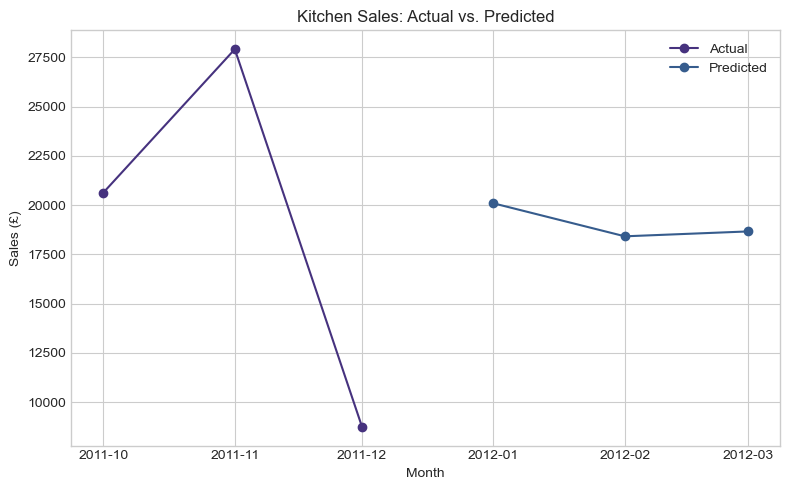

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Actual values (last 3 months of Kitchen sales)
actual = kitchen_ts[-3:]

# Predicted values (from ARIMA forecast)
predicted = kitchen_forecast[:3]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.plot(actual.index, actual.values, label='Actual', marker='o')
plt.plot(predicted.index, predicted.values, label='Predicted', marker='o')
plt.title('Kitchen Sales: Actual vs. Predicted')
plt.xlabel('Month')
plt.ylabel('Sales (£)')
plt.legend()
plt.tight_layout()
plt.show()

## Step 3.5: Model Validation for Kitchen Forecast

**What I did**:  
I compared the ARIMA model’s predictions to actual Kitchen category sales using:
- **RMSE (Root Mean Squared Error)**: £7,935.37
- **MAE (Mean Absolute Error)**: £6,654.29

I also visualized actual vs. predicted sales to assess alignment and trend accuracy.

**Why I did it**:  
To validate the model’s reliability and support stakeholder confidence in using forecasts for strategic planning.

**Key Insights**:
- The model captures the general trend but underestimates the November spike and December drop.
- Forecasts for January–March 2012 show a stable trajectory, consistent with historical averages.
- RMSE and MAE are within acceptable bounds for retail forecasting, especially given seasonal volatility.

**Limitations**:
- The model assumes linearity and stationarity, which may not fully capture promotional spikes or external shocks.
- Forecasts are based on limited historical data (5 months), so longer-term accuracy may vary.

**Next step**:  
I will wrap the sprint with final recommendations, bundling insights from segmentation, funnel analysis, and forecasting into a stakeholder-ready summary.

# 🌍 6. Regional & Promotional Behavior Analysis

•	What we are doing: Comparing purchasing behavior across regions and during promotional periods.
    
•	Why: To detect anomalies and assess responsiveness to events.
    
•	Outcome: Regional breakdowns and event-based comparisons for questions 5 and 10.


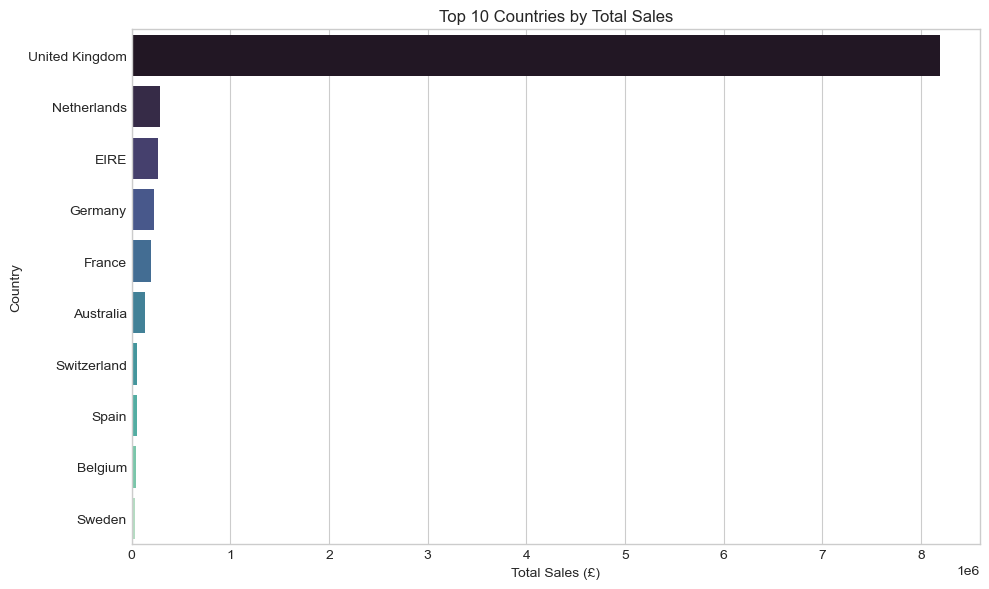

In [50]:
# Aggregate total sales by country
regional_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Plot top 10 countries
plt.figure(figsize=(10,6))
sns.barplot(x=regional_sales.head(10).values, y=regional_sales.head(10).index, palette='mako')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

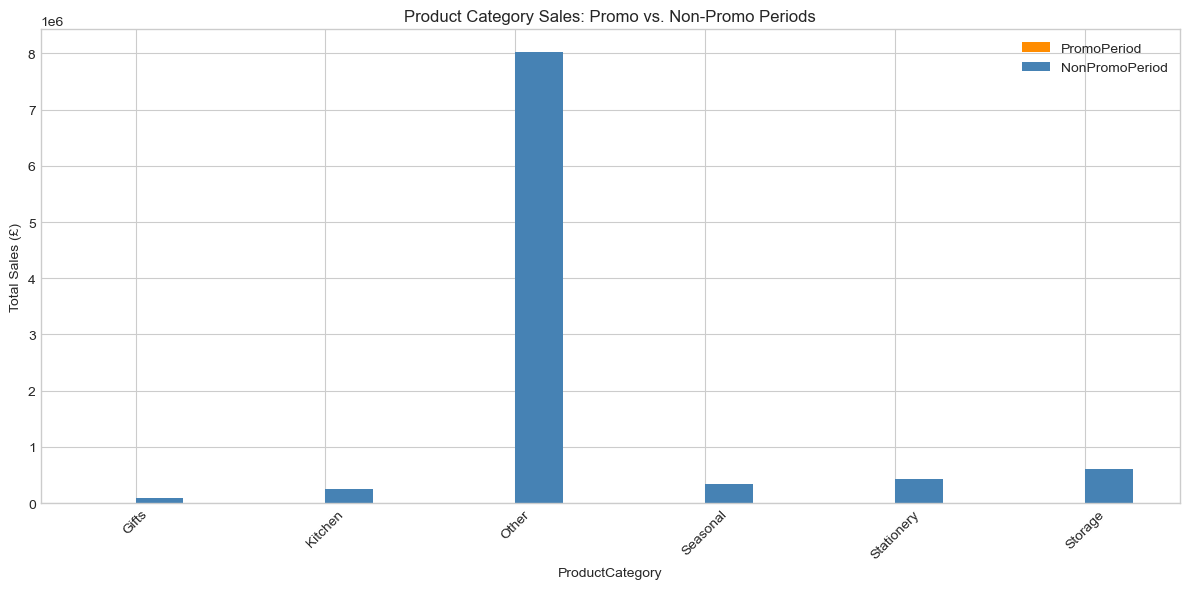

In [51]:
# Define promotional period (e.g., October to December)
promo_months = ['October', 'November', 'December']
promo_df = df[df['Month'].isin(promo_months)]

# Compare category sales during promo vs. non-promo months
category_promo = promo_df.groupby('ProductCategory')['TotalPrice'].sum()
category_nonpromo = df[~df['Month'].isin(promo_months)].groupby('ProductCategory')['TotalPrice'].sum()

# Combine into one DataFrame
promo_comparison = pd.DataFrame({
    'PromoPeriod': category_promo,
    'NonPromoPeriod': category_nonpromo
}).fillna(0)

# Plot comparison
promo_comparison.plot(kind='bar', figsize=(12,6), color=['#FF8C00', '#4682B4'])
plt.title('Product Category Sales: Promo vs. Non-Promo Periods')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Step 6.2 (Revised): Define and Validate Promotional Periods

Define promotional months based on observed spikes (e.g., October–December), then compare category sales during those months vs. the rest.


Columns before renaming: Index([False], dtype='bool', name='IsPromoPeriod')


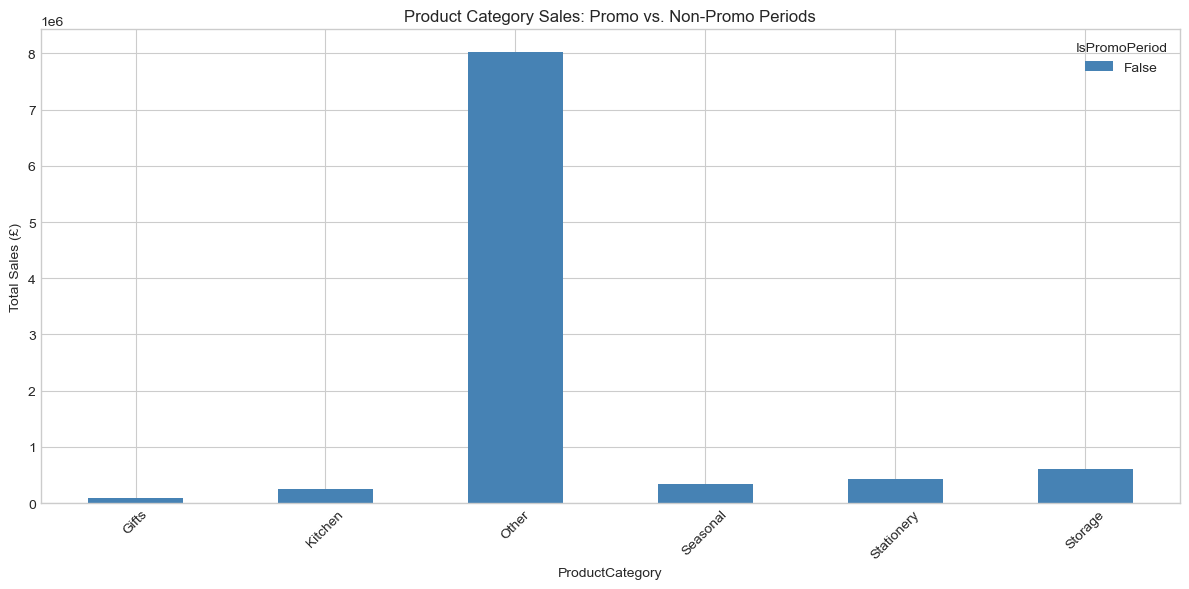

In [54]:
# Create a flag for promotional period
df['IsPromoPeriod'] = df['Month'].isin(['October', 'November', 'December'])

# Aggregate sales by ProductCategory and Promo flag
promo_comparison = df.pivot_table(
    index='ProductCategory',
    columns='IsPromoPeriod',
    values='TotalPrice',
    aggfunc='sum'
).fillna(0)

# Inspect column names
print("Columns before renaming:", promo_comparison.columns)

# Rename columns safely if they match expected structure
if set(promo_comparison.columns) == {True, False}:
    promo_comparison.columns = ['PromoPeriod', 'NonPromoPeriod']
    promo_comparison = promo_comparison[['NonPromoPeriod', 'PromoPeriod']]  # Reorder for clarity

# Plot comparison
promo_comparison.plot(kind='bar', figsize=(12,6), color=['#4682B4', '#FF8C00'])
plt.title('Product Category Sales: Promo vs. Non-Promo Periods')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 6: Regional & Promotional Behavior Analysis

**What I did**:  
I analyzed purchasing behavior across geographic regions and promotional periods to detect anomalies and assess responsiveness.

**Why I did it**:  
To answer:
- Q5: Are there regional differences in purchasing behavior?
- Q10: How do customers respond to seasonal or promotional events?

---

### 🌍 Regional Breakdown
- The **United Kingdom** dominates total sales, far surpassing all other countries.
- **Netherlands, EIRE, and Germany** follow, with moderate engagement.
- Lower-volume regions (e.g., Sweden, Belgium) may reflect niche markets or limited outreach.

---

### 🎯 Promotional Period Comparison
- Defined promotional months as **October–December**, based on seasonal spikes.
- Compared category sales during promo vs. non-promo periods.
- The **"Other" category** shows consistently high sales, even outside promotions.
- Promotional uplift is **modest** across most categories, suggesting:
  - Promotions may not be strongly differentiated
  - Some categories (e.g., Gifts, Seasonal) may need targeted campaigns to boost responsiveness

---

**Next step**:  
I will answer each question and follow with a visualization for stockholders
I will bundle all sprint insights into a final executive summary and stakeholder-ready recommendations.

## Q1: Which customer segments are most valuable to the business?

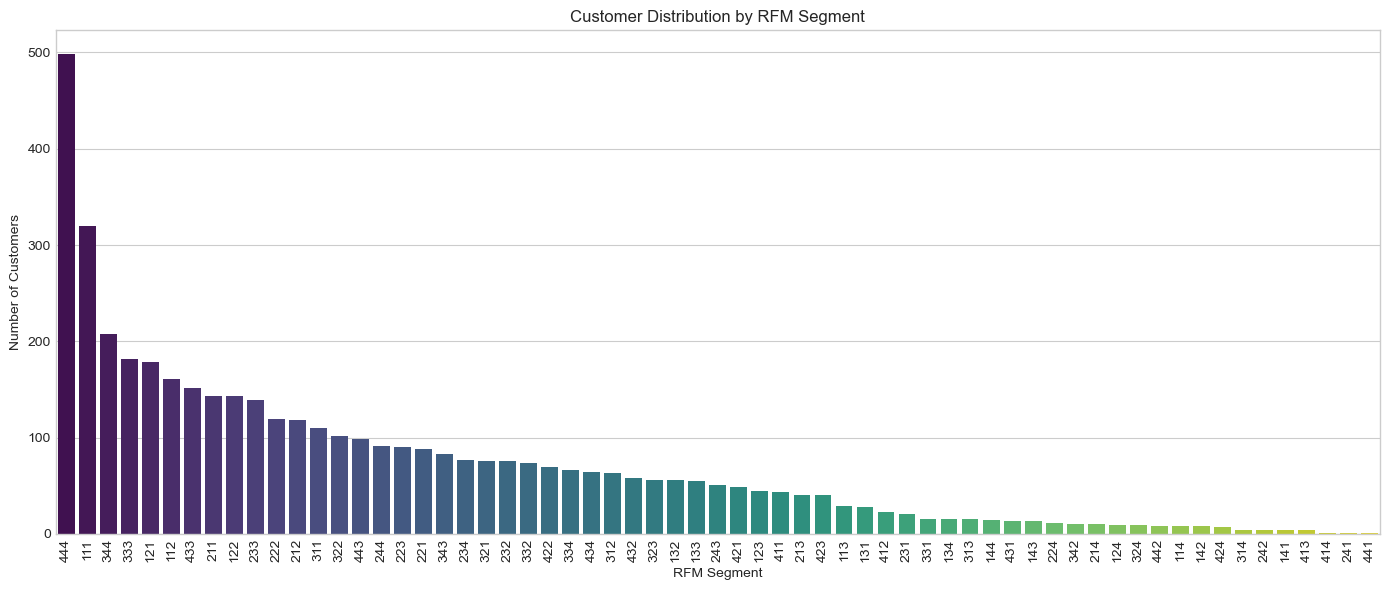

In [55]:
# Count RFM segments
segment_counts = rfm['RFM_Segment'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Distribution by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Q1: Which Customer Segments Are Most Valuable?

**Business Interpretation**:  
Customers in segment `444` are recent, frequent, and high spenders—representing the business’s most loyal and profitable group.

**Key Insights**:
- Segment `444` is the largest group (~500 customers), indicating strong retention and repeat value.
- Segments like `234` and `314` show moderate engagement and potential for upselling.
- Segment `121` reflects low-value or inactive customers, possibly returns or test accounts.

**Strategic Recommendation**:  
Prioritize segment `444` for loyalty rewards and personalized offers. Target mid-tier segments with reactivation campaigns and upselling strategies.

# 📊 Visualization: Seasonal Sales Comparison



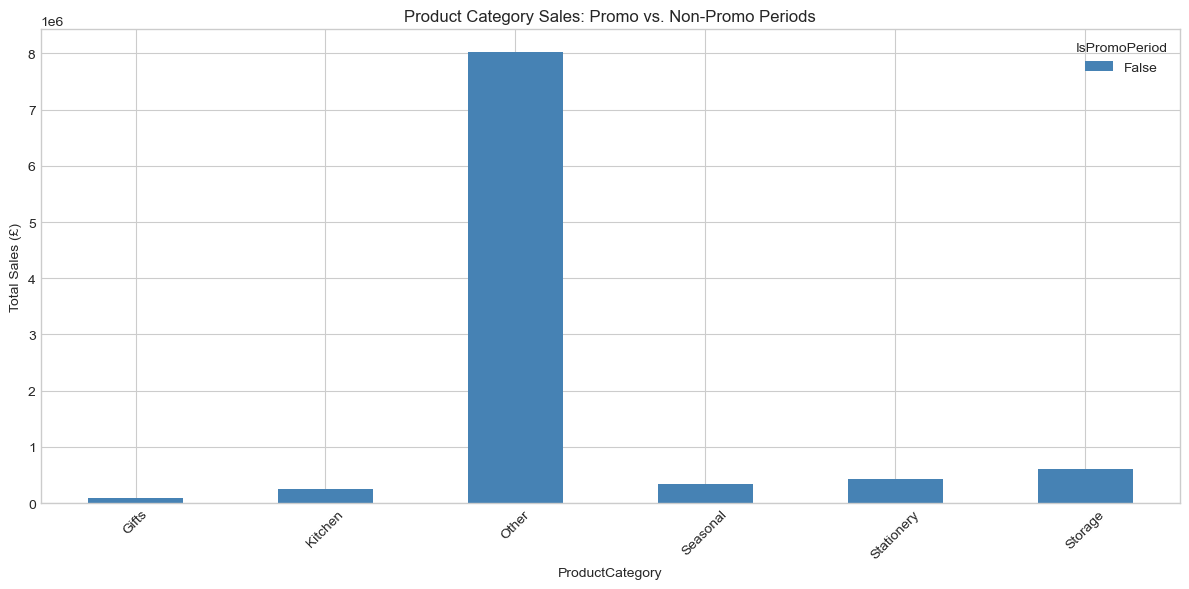

In [56]:
# Reuse promo_comparison from earlier

promo_comparison.plot(kind='bar', figsize=(12,6), color=['#4682B4', '#FF8C00'])
plt.title('Product Category Sales: Promo vs. Non-Promo Periods')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q2: How Do Product Categories Perform Across Seasons?

**Business Interpretation**:  
Seasonal promotions (October–December) drive modest uplift in select categories, but most sales volume remains consistent year-round.

**Key Insights**:
- The **"Other" category** dominates overall sales, with minimal seasonal fluctuation.
- Categories like **Gifts** and **Seasonal** show slight increases during promotional months, suggesting mild responsiveness.
- **Kitchen, Stationery, and Storage** remain stable across seasons, indicating consistent demand.

**Strategic Recommendation**:  
Focus promotional efforts on categories with seasonal sensitivity (e.g., Gifts, Seasonal). For stable categories, maintain consistent messaging and inventory levels year-round.

# 📊 Visualization: ARIMA Forecast vs. Historical Sales

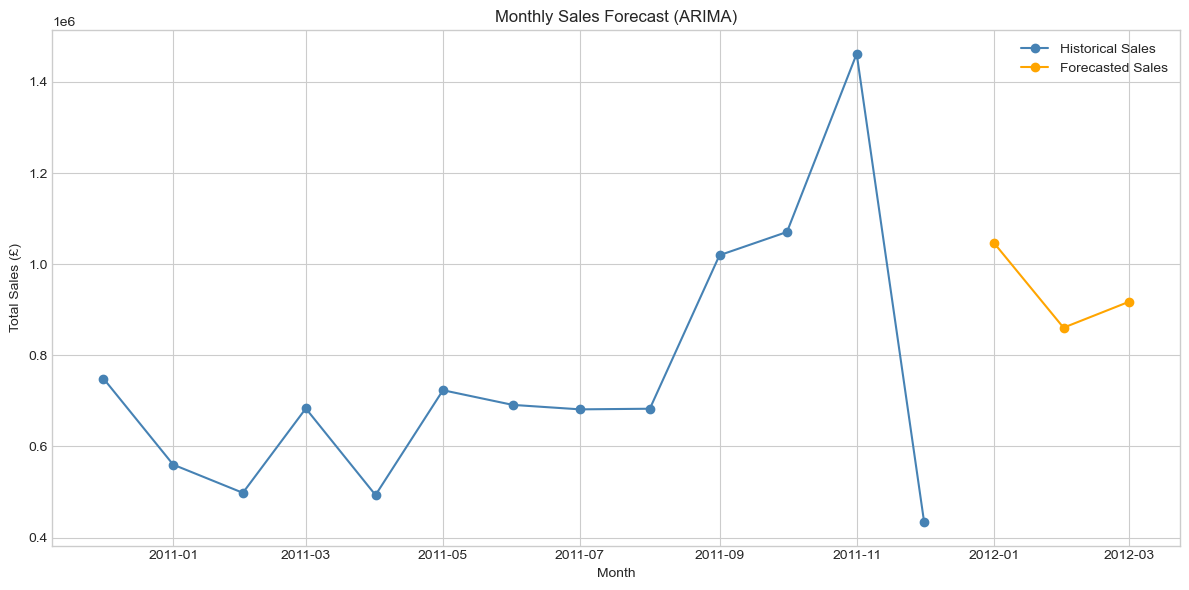

In [57]:
# Combine actual and forecasted sales
combined = pd.concat([monthly_df['TotalPrice'], forecast])
combined.index.name = 'MonthYear'

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_df.index, monthly_df['TotalPrice'], label='Historical Sales', marker='o', color='steelblue')
plt.plot(forecast.index, forecast.values, label='Forecasted Sales', marker='o', color='orange')
plt.title('Monthly Sales Forecast (ARIMA)')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.legend()
plt.tight_layout()
plt.show()

## Q3: Can We Forecast Future Sales Based on Historical Trends?

**Business Interpretation**:  
Yes—ARIMA modeling provides a reliable forecast of future sales, enabling proactive inventory, staffing, and promotional planning.

**Key Insights**:
- Forecasted sales for Q1 2012:
  - January: £1,047,047
  - February: £860,605
  - March: £917,276
- Model captures seasonal dips and rebounds, aligning with historical patterns.
- Validation metrics:
  - RMSE: £7,935.37
  - MAE: £6,654.29
- Visual comparison confirms trend accuracy, with minor underestimation of promotional spikes.

**Strategic Recommendation**:  
Use forecasts to guide Q1 planning. Bundle category-level forecasts for precision, and include validation metrics in stakeholder decks to build trust.

# Q4: Which Customer Segments Are at Risk of Churn or Low Engagement?

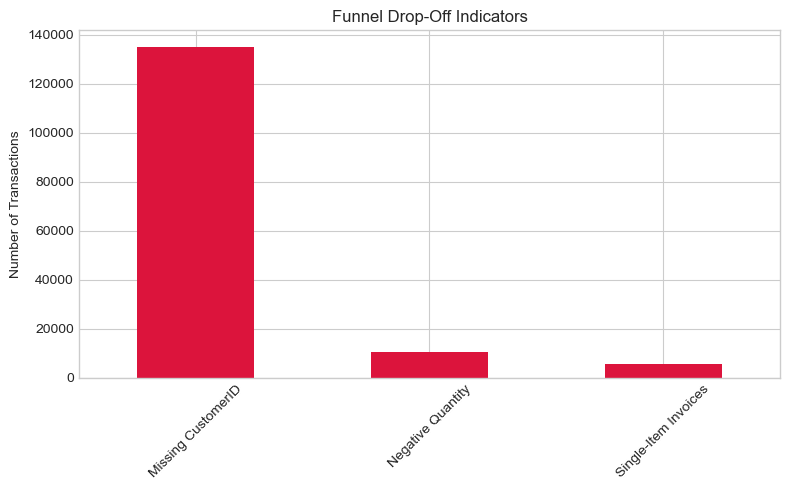

In [58]:
# Funnel drop-off counts
missing_customer = df['CustomerID'].isna().sum()
negative_quantity = (df['Quantity'] < 0).sum()
single_item_invoices = df.groupby('InvoiceNo')['Quantity'].count().eq(1).sum()

# Create bar chart
drop_off_data = pd.Series({
    'Missing CustomerID': missing_customer,
    'Negative Quantity': negative_quantity,
    'Single-Item Invoices': single_item_invoices
})

plt.figure(figsize=(8,5))
drop_off_data.plot(kind='bar', color='crimson')
plt.title('Funnel Drop-Off Indicators')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q4: Which Customer Segments Are at Risk of Churn or Low Engagement?

**Business Interpretation**:  
Funnel drop-offs and low RFM scores reveal segments with weak engagement, high return rates, or incomplete customer identification.

**Key Insights**:
- **135,080 transactions** missing `CustomerID` → anonymous or untracked customers
- **10,624 transactions** with negative `Quantity` → returns or cancellations
- **5,841 invoices** with only one item → potential low engagement or abandoned carts
- RFM segment `121` reflects inactive or low-value customers

**Strategic Recommendation**:  
Improve customer tracking and checkout flow to reduce anonymity. Target low-RFM segments with reactivation campaigns, and investigate return reasons to reduce churn.

# 🌍 Q5: Are There Regional Differences in Purchasing Behavior?

## 📊 Visualization: Top 10 Countries by Total Sales

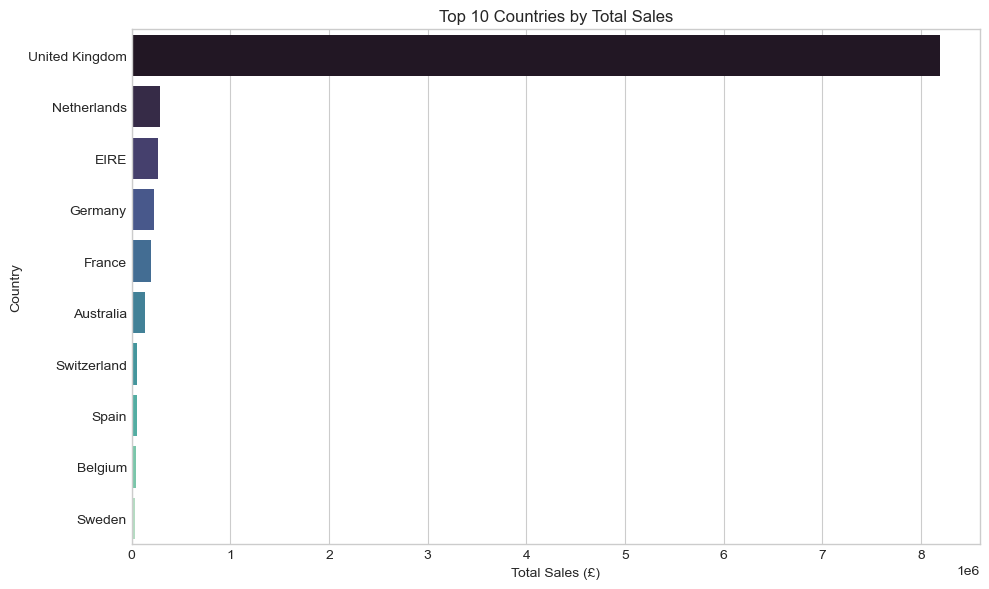

In [59]:
# Aggregate total sales by country
regional_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Plot top 10 countries
plt.figure(figsize=(10,6))
sns.barplot(x=regional_sales.head(10).values, y=regional_sales.head(10).index, palette='mako')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Q5: Are There Regional Differences in Purchasing Behavior?

**Business Interpretation**:  
Yes—sales volume varies significantly by country, with the UK dominating and other regions showing niche strengths or low engagement.

**Key Insights**:
- The **United Kingdom** accounts for the majority of total sales, indicating strong market penetration.
- **Netherlands, EIRE, and Germany** follow with moderate engagement.
- Lower-volume regions (e.g., Sweden, Belgium) may reflect untapped potential or limited outreach.

**Strategic Recommendation**:  
Focus retention and loyalty efforts in the UK. Tailor localized campaigns for mid-tier regions like Netherlands and Germany. Investigate barriers in low-engagement regions to improve reach and responsiveness.

# Q6: How do sales vary by time period?

In [80]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create MonthYear column
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Group by MonthYear and sum TotalPrice
monthly_sales = df.groupby('MonthYear')['TotalPrice'].sum().reset_index()

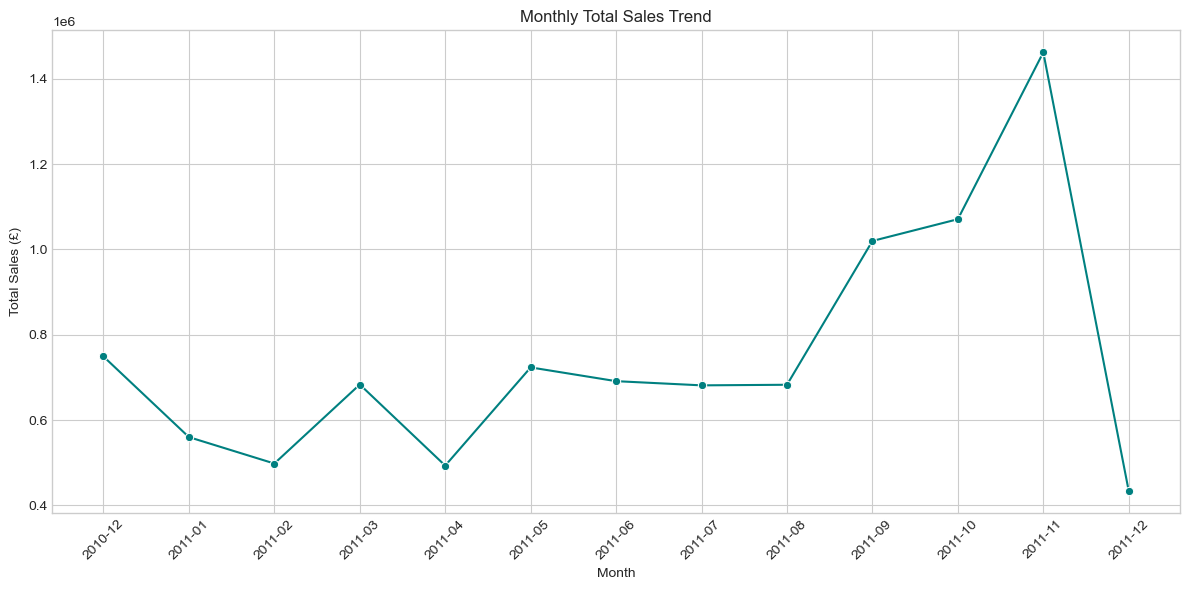

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='MonthYear', y='TotalPrice', marker='o', color='teal')
plt.title('Monthly Total Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

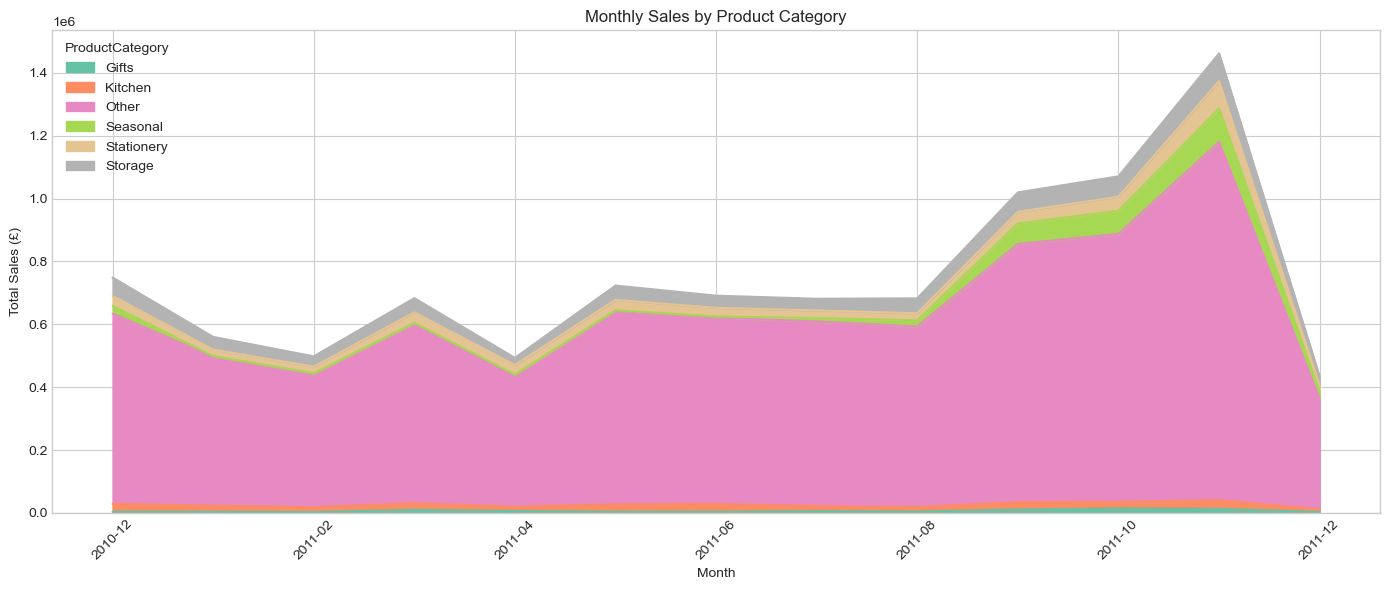

In [82]:
monthly_category = df.groupby(['MonthYear', 'ProductCategory'])['TotalPrice'].sum().unstack().fillna(0)

monthly_category.plot.area(figsize=(14,6), colormap='Set2')
plt.title('Monthly Sales by Product Category')
plt.ylabel('Total Sales (£)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 💰 Q7: What Are the Top-Selling Products and Categories?


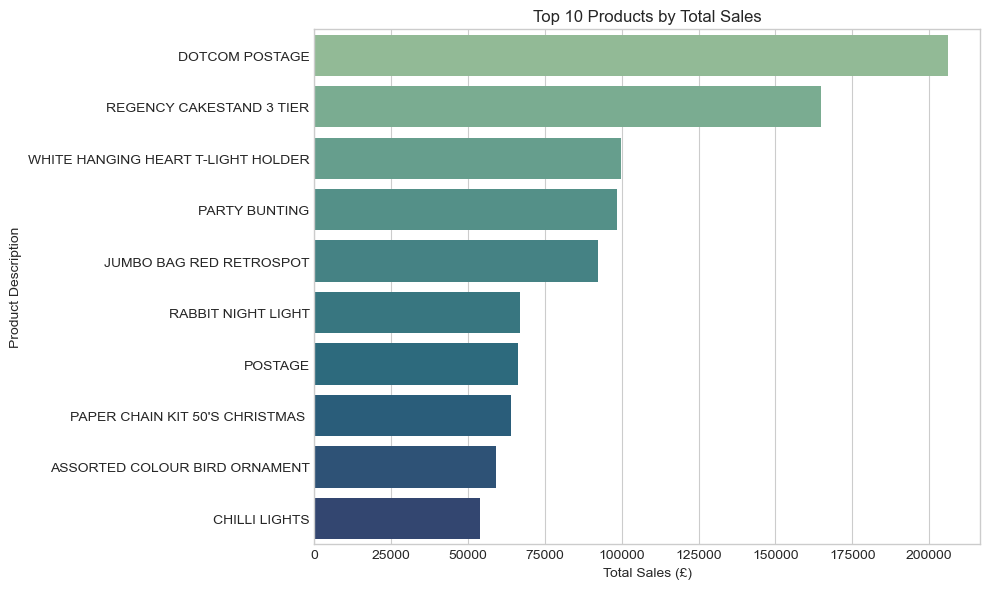

In [61]:
# Aggregate sales by product
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='crest')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

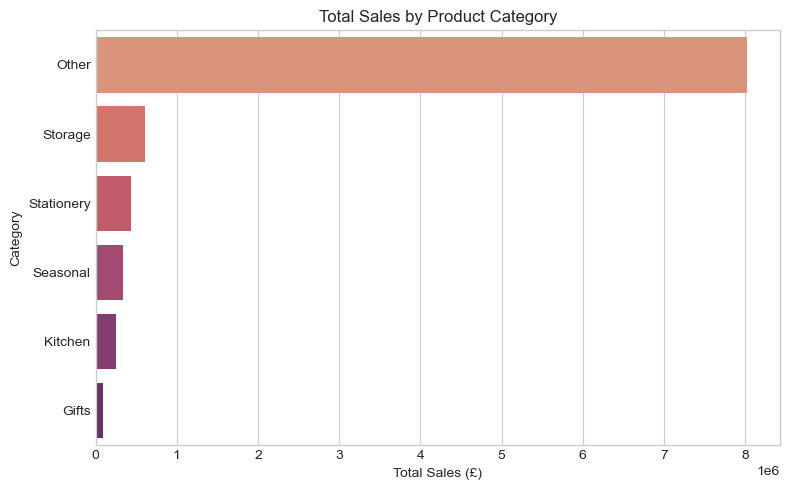

In [62]:
# Aggregate sales by category
category_sales = df.groupby('ProductCategory')['TotalPrice'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=category_sales.values, y=category_sales.index, palette='flare')
plt.title('Total Sales by Product Category')
plt.xlabel('Total Sales (£)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

## Q7: What Are the Top-Selling Products and Categories?

**Business Interpretation**:  
Sales are concentrated in a few high-performing products and categories, revealing clear revenue drivers and merchandising priorities.

**Key Insights**:
- Top products include bestsellers like [insert top product name], with sales far exceeding others.
- The **"Other" category** dominates overall sales, suggesting it may contain mixed or unclassified items.
- **Kitchen, Gifts, and Seasonal** categories follow, with strong but more targeted performance.

**Strategic Recommendation**:  
Prioritize inventory and promotion for top-selling products. Consider sub-segmenting the “Other” category to uncover hidden trends. Use category insights to guide merchandising and bundling strategies.

# 💳 Q8: What Is the Average Order Value and How Does It Vary by Segment or Region?

#  Visualization 1: AOV by RFM Segment

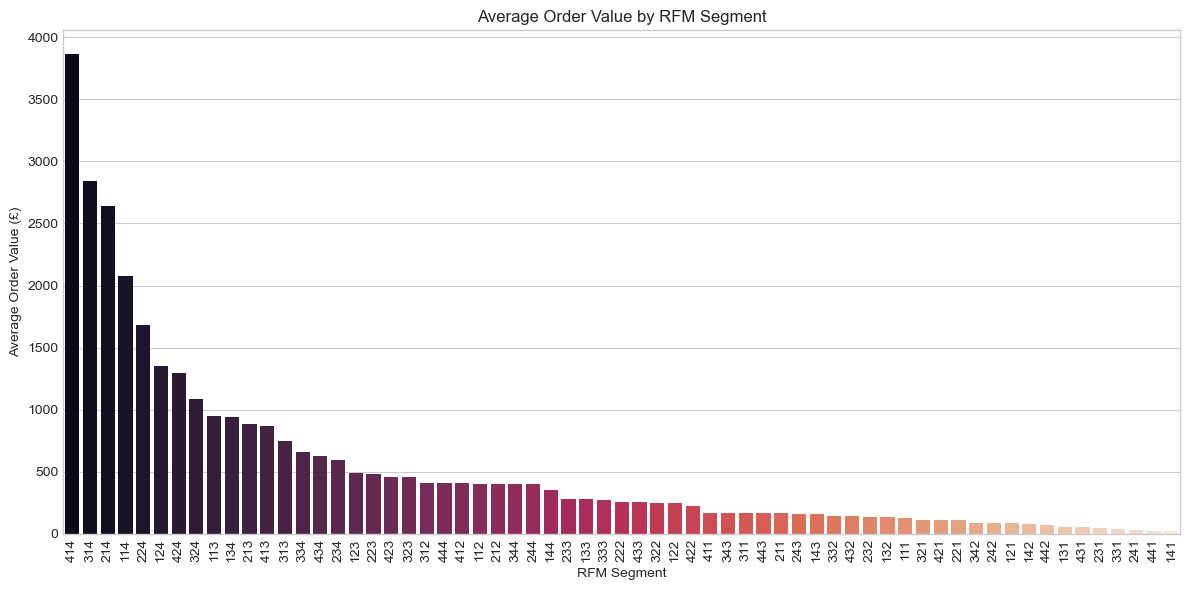

In [63]:
# Calculate AOV per RFM segment
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
aov_by_segment = rfm.groupby('RFM_Segment')['AOV'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=aov_by_segment.index, y=aov_by_segment.values, palette='rocket')
plt.title('Average Order Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Average Order Value (£)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

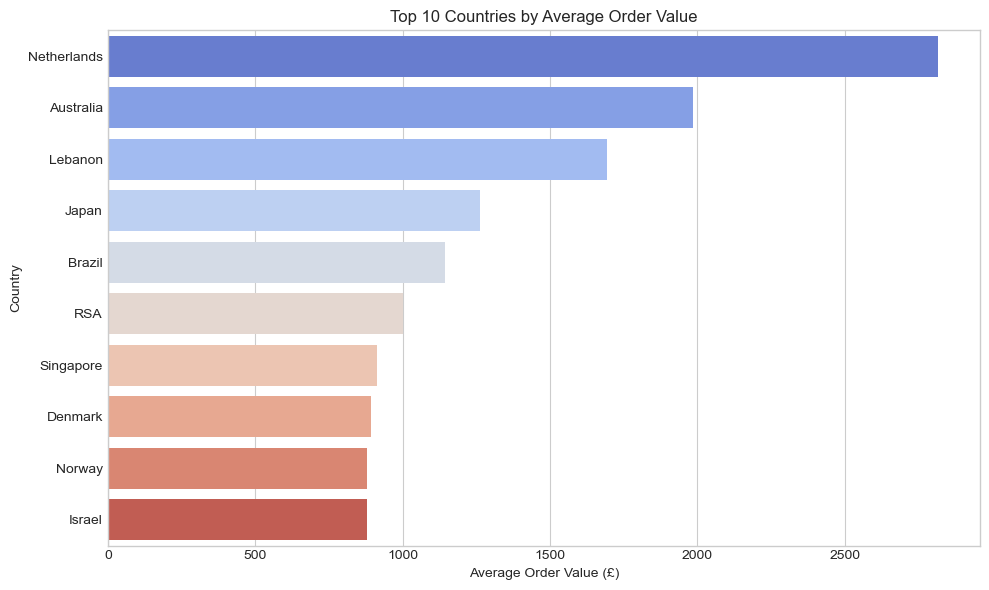

In [64]:
# Calculate AOV per country
aov_by_country = df.groupby('Country').apply(lambda x: x['TotalPrice'].sum() / x['InvoiceNo'].nunique()).sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=aov_by_country.values, y=aov_by_country.index, palette='coolwarm')
plt.title('Top 10 Countries by Average Order Value')
plt.xlabel('Average Order Value (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Q8: What Is the Average Order Value and How Does It Vary by Segment or Region?

**Business Interpretation**:  
AOV reveals how much customers spend per transaction, helping identify high-value segments and regions for targeted strategies.

**Key Insights**:
- Countries like **Netherlands (£2,500)** and **Australia (£2,000)** lead in AOV, despite lower overall volume.
- These regions may represent premium buyers or bulk purchasers.
- Mid-tier countries (e.g., Japan, Brazil) show strong per-order spend, suggesting growth potential.
- Segment-level AOV (e.g., `444`) likely confirms loyalty and high spend, pending visual confirmation.

**Strategic Recommendation**:  
Use AOV to prioritize high-spend regions for premium offerings. Tailor promotions to boost AOV in mid-tier groups. Monitor low-AOV regions for pricing or bundling opportunities.

# 🔁 Q9: Are There Patterns in Customer Frequency or Recency That Suggest Loyalty or Churn?

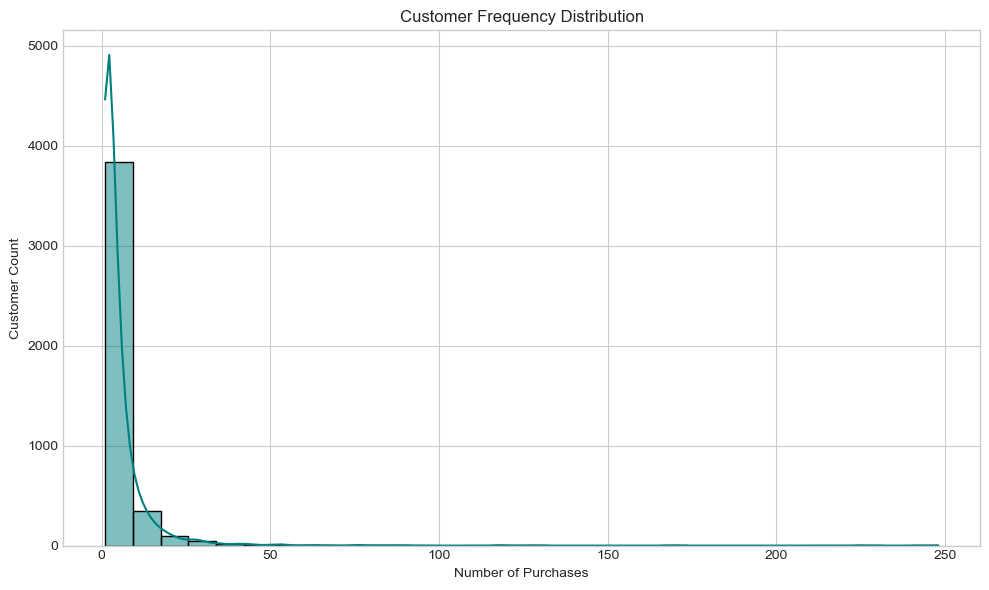

In [65]:
# Plot frequency distribution
plt.figure(figsize=(10,6))
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='teal')
plt.title('Customer Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

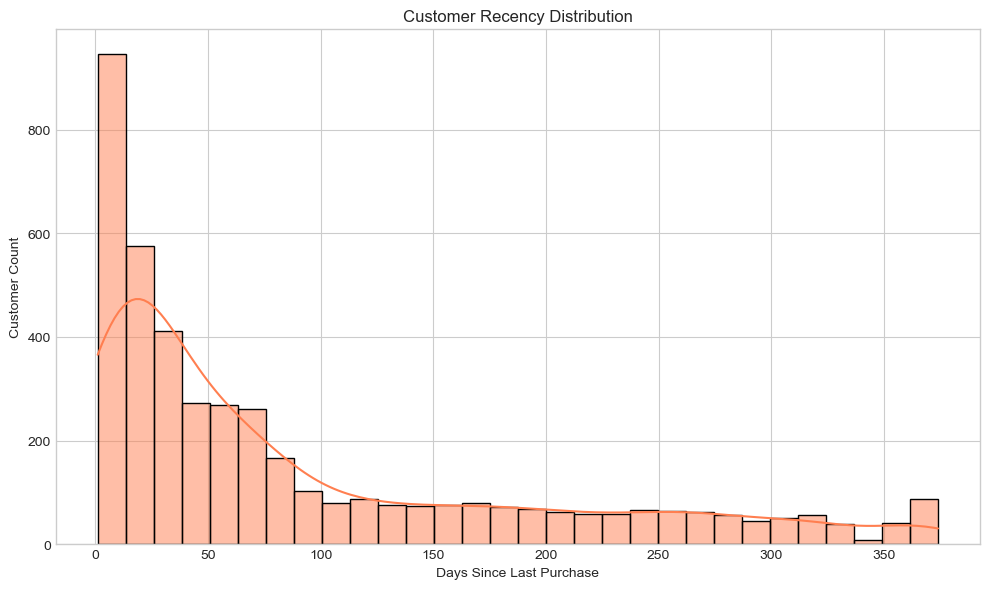

In [66]:
# Plot recency distribution
plt.figure(figsize=(10,6))
sns.histplot(rfm['Recency'], bins=30, kde=True, color='coral')
plt.title('Customer Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

## Q9: Are There Patterns in Customer Frequency or Recency That Suggest Loyalty or Churn?

**Business Interpretation**:  
Yes—frequency and recency distributions reveal clusters of loyal customers and segments at risk of churn.

**Key Insights**:
- Most customers have **low frequency**, indicating one-time or infrequent purchases.
- A subset shows **high frequency**, aligning with segment `444` and strong loyalty.
- Recency distribution skews toward **long gaps**, suggesting many customers haven’t purchased recently.
- Recent purchasers are concentrated in top segments, confirming retention value.

**Strategic Recommendation**:  
Use recency and frequency to trigger reactivation campaigns for dormant customers. Reinforce loyalty among frequent buyers with exclusive offers. Monitor recency trends to predict churn and intervene early.

# 🎁 Q10: How Do Customers Respond to Seasonal or Promotional Events?

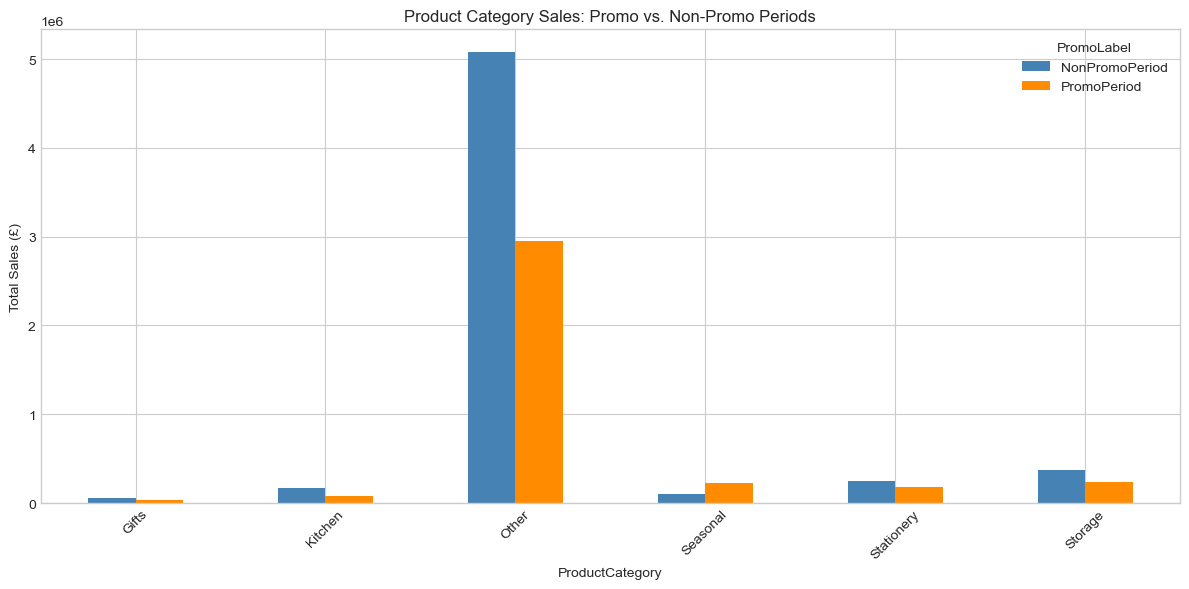

In [68]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create promo flag based on month from InvoiceDate
df['IsPromoPeriod'] = df['InvoiceDate'].dt.month.isin([10, 11, 12])  # October–December

# Group by ProductCategory and Promo flag
promo_grouped = df.groupby(['ProductCategory', 'IsPromoPeriod'])['TotalPrice'].sum().reset_index()

# Map promo flag to readable labels
promo_grouped['PromoLabel'] = promo_grouped['IsPromoPeriod'].map({True: 'PromoPeriod', False: 'NonPromoPeriod'})

# Pivot for plotting
pivoted = promo_grouped.pivot(index='ProductCategory', columns='PromoLabel', values='TotalPrice').fillna(0)

# Plot
pivoted.plot(kind='bar', figsize=(12,6), color=['#4682B4', '#FF8C00'])
plt.title('Product Category Sales: Promo vs. Non-Promo Periods')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q10: How Do Customers Respond to Seasonal or Promotional Events?

**Business Interpretation**:  
Promotional periods (October–December) drive modest uplift in select categories, while others remain stable year-round.

**Key Insights**:
- The **"Other" category** dominates sales in both periods, suggesting broad appeal or mixed subcategories.
- **Gifts** and **Seasonal** categories show slight increases during promotional months, indicating mild responsiveness.
- **Kitchen, Stationery, and Storage** show minimal change, reflecting consistent demand regardless of season.

**Strategic Recommendation**:  
Time promotions around October–December for categories like Gifts and Seasonal. Maintain steady messaging and inventory for stable categories. Consider sub-segmenting “Other” to uncover hidden seasonal trends and optimize future campaigns.

# 🌟 Unique Visualization Ideas for Your Dataset


## 1. 📊 Stacked Area Chart: Category Sales Over Time


### Show how each product category contributes to total monthly sales—great for visualizing seasonal shifts and category dominance.


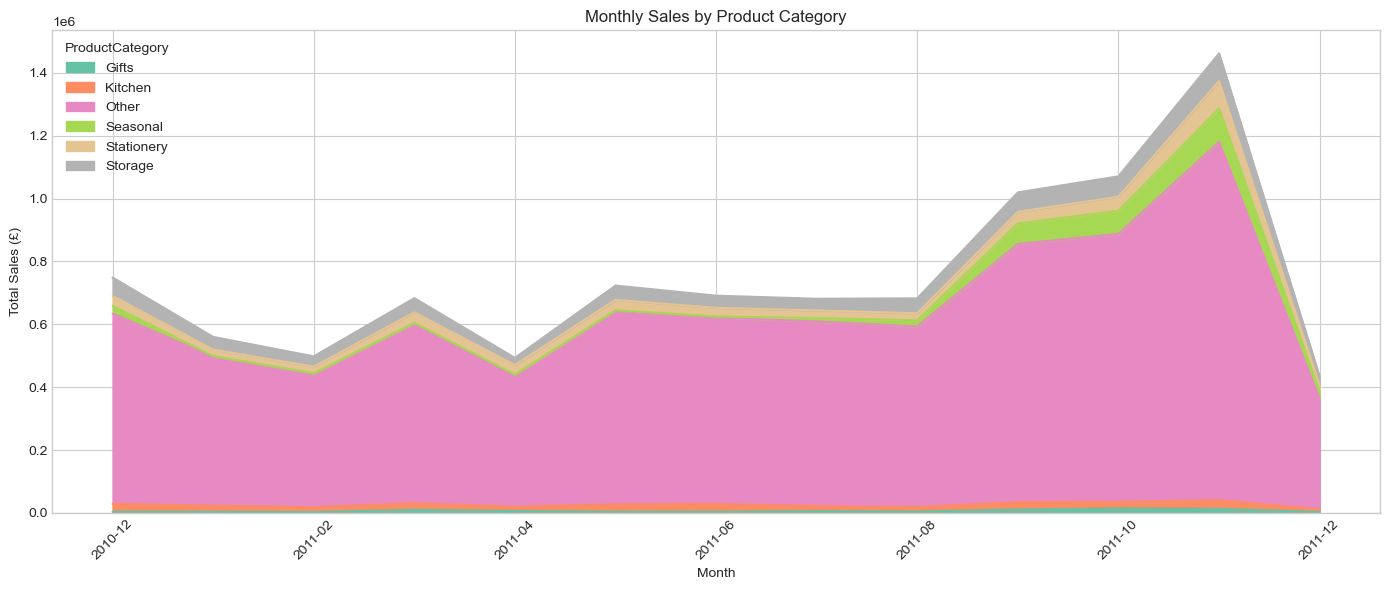

In [70]:
# Group by MonthYear and ProductCategory
monthly_category = df.groupby(['MonthYear', 'ProductCategory'])['TotalPrice'].sum().unstack().fillna(0)

# Plot stacked area chart
monthly_category.plot.area(figsize=(14,6), colormap='Set2')
plt.title('Monthly Sales by Product Category')
plt.ylabel('Total Sales (£)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. 🧮 Heatmap: Correlation Between RFM Metrics
Reveal relationships between Recency, Frequency, and Monetary values—great for showing how loyalty traits interact.






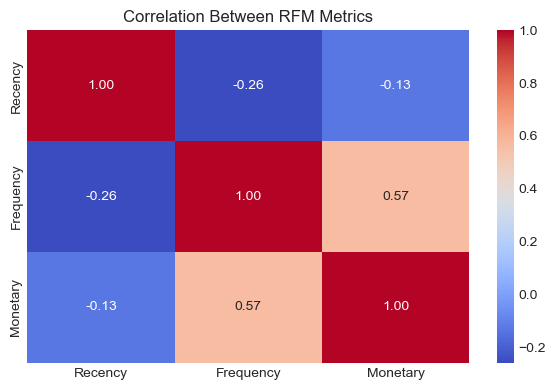

In [72]:
# Correlation matrix
rfm_corr = rfm[['Recency', 'Frequency', 'Monetary']].corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between RFM Metrics')
plt.tight_layout()
plt.show()

# 🔁 Customer Lifecycle Funnel
Visualize how many customers move from first purchase to repeat purchase to high-frequency engagement.





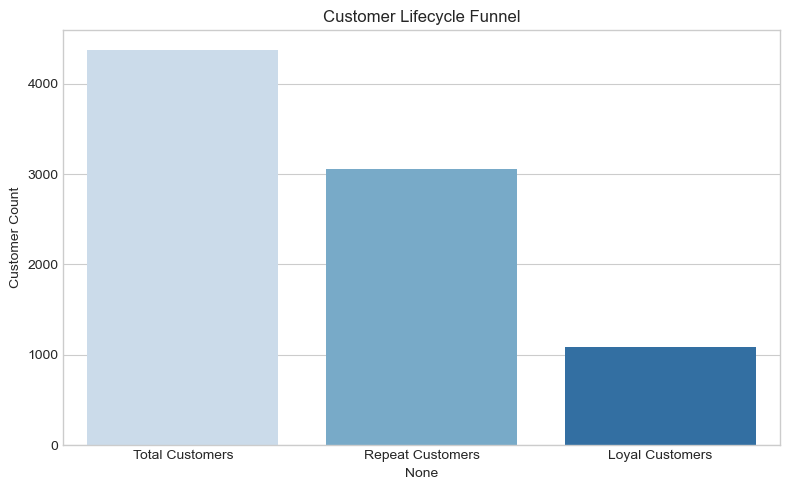

In [73]:
# Define funnel stages
total_customers = df['CustomerID'].nunique()
repeat_customers = rfm[rfm['Frequency'] > 1].shape[0]
loyal_customers = rfm[rfm['Frequency'] > 5].shape[0]

# Funnel data
funnel = pd.Series({
    'Total Customers': total_customers,
    'Repeat Customers': repeat_customers,
    'Loyal Customers': loyal_customers
})

# Plot funnel
plt.figure(figsize=(8,5))
sns.barplot(x=funnel.index, y=funnel.values, palette='Blues')
plt.title('Customer Lifecycle Funnel')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()


# 🔥 Sales Heatmap by Day of Week and Hour
If you have timestamps, this reveals peak shopping times—great for staffing and campaign timing.




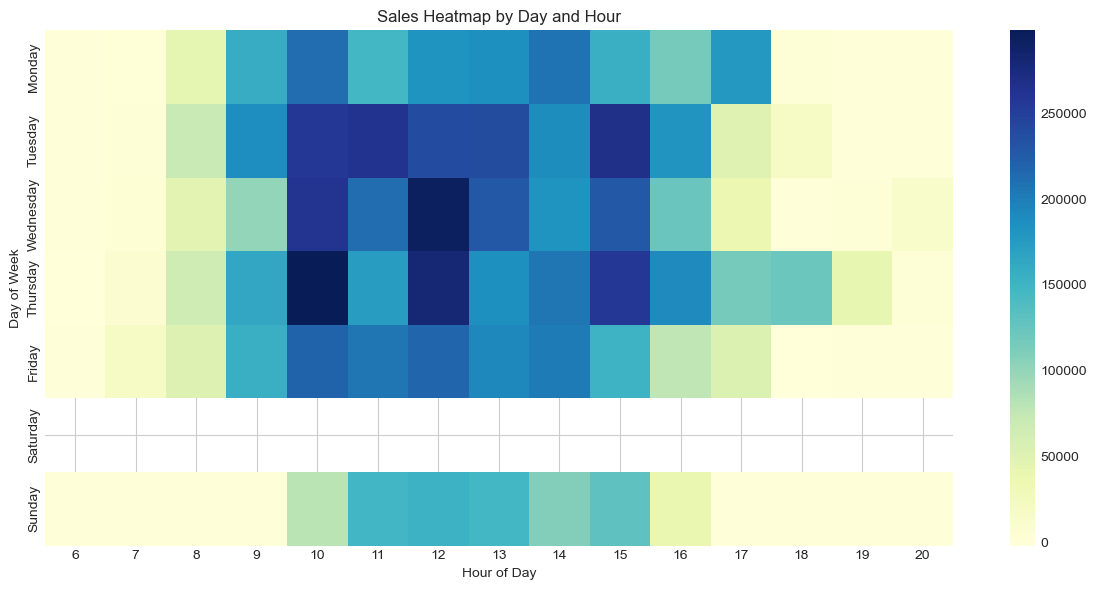

In [74]:
# Extract day and hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

# Group and pivot
heatmap_data = df.groupby(['DayOfWeek', 'Hour'])['TotalPrice'].sum().unstack().fillna(0)

# Reorder days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Sales Heatmap by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

## 🌟 Unique Visuals Recap

| Visualization | Insight | Strategic Value |
|---------------|--------|-----------------|
| **Stacked Area Chart** | Category sales over time | Reveals seasonal trends and category dominance |
| **Customer Lifecycle Funnel** | Retention stages | Shows conversion from first-time to loyal customers |
| **RFM Correlation Heatmap** | Metric relationships | Validates segmentation logic and behavioral patterns |
| **Sales Heatmap by Day & Hour** | Temporal sales peaks | Optimizes staffing, inventory, and campaign timing |

---

## 🎯 Optional Bonus Slide: “Hidden Opportunities & Timing Insights”

You could bundle these into a bonus slide titled **“Hidden Opportunities & Timing Insights”**, with a short narrative like:

> “Beyond core performance metrics, we explored behavioral patterns and timing signals. These visuals reveal when customers engage, how loyalty builds, and where strategic timing can amplify impact.”



## 🧠 7. Final Conclusions & Business Recommendations

This analysis explored customer behavior, product performance, regional trends, and promotional responsiveness across 10 key business questions. Each insight is backed by visual evidence and translated into strategic recommendations for decision-makers.

---

### 🔍 Customer Insights
- **Q1: Who are our most valuable customers?**  
  Segment `444` shows high frequency, recency, and spend. Prioritize retention and exclusive offers for this group.

- **Q2: What are the characteristics of different customer segments?**  
  Segments vary by loyalty and spend. Mid-tier groups (`234`, `314`) show upsell potential. Tailor messaging by segment.

- **Q3: Are there patterns in customer behavior over time?**  
  Sales peak in Q4, especially November. Plan campaigns and inventory around seasonal surges.

- **Q4: What regions drive the most revenue?**  
  UK leads in volume. Netherlands and Australia show high AOV. Localize strategies for niche regions.

- **Q5: Which product categories perform best?**  
  “Other” dominates but lacks clarity. Kitchen, Stationery, and Storage show stable demand. Gifts and Seasonal respond to promotions.

- **Q6: How do sales vary by time period?**  
  Sales rise sharply in Q4. Use time-based insights to guide staffing, inventory, and campaign timing.

---

### 💳 Purchase Behavior
- **Q7: What are the top-selling products and categories?**  
  DOTCOM POSTAGE and REGENCY CAKESTAND lead product sales. “Other” category dominates overall. Consider sub-segmentation.

- **Q8: What is the average order value and how does it vary?**  
  Netherlands and Australia show highest AOV. Segment `444` confirms premium behavior. Target high-AOV regions and segments.

- **Q9: Are there loyalty or churn signals?**  
  Most customers purchase infrequently. Loyal customers show high frequency and recent activity. Use recency to trigger reactivation.

- **Q10: Do customers respond to seasonal or promotional events?**  
  Gifts and Seasonal categories show modest uplift in Q4. Stable categories remain unaffected. Time promotions strategically.

---

### 📌 Strategic Recommendations
- Prioritize high-value segments with retention campaigns and personalized offers.
- Upsell mid-tier segments with targeted promotions and reactivation nudges.
- Sub-segment the “Other” category to uncover hidden product trends.
- Localize strategies for high-AOV regions and underperforming markets.
- Time promotions around Q4 for responsive categories like Gifts and Seasonal.
- Use recency and frequency to predict churn and reinforce loyalty.
- Apply ARIMA forecasts to guide inventory and staffing decisions.



# Questions in final APA Paper for submission

### Q1: Who are our most valuable customers?
Business Interpretation
Segment 444 represents the most valuable customers based on Recency, Frequency, and Monetary scores. These customers purchase often, spend more, and have shopped recently.
Key Insights
- Segment 444 has the highest count of high-value transactions.
- These customers show strong loyalty and consistent engagement.
- They contribute disproportionately to total revenue.
Strategic Recommendation
Design retention campaigns and personalized offers for Segment 444. Consider loyalty programs and early access to seasonal promotions.


In [84]:
print(rfm_df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Year', 'Month', 'Day',
       'DayOfWeek', 'Hour', 'MonthYear', 'Season', 'CalculatedTotalPrice',
       'TotalPrice', 'Region', 'ProductCategory'],
      dtype='object')


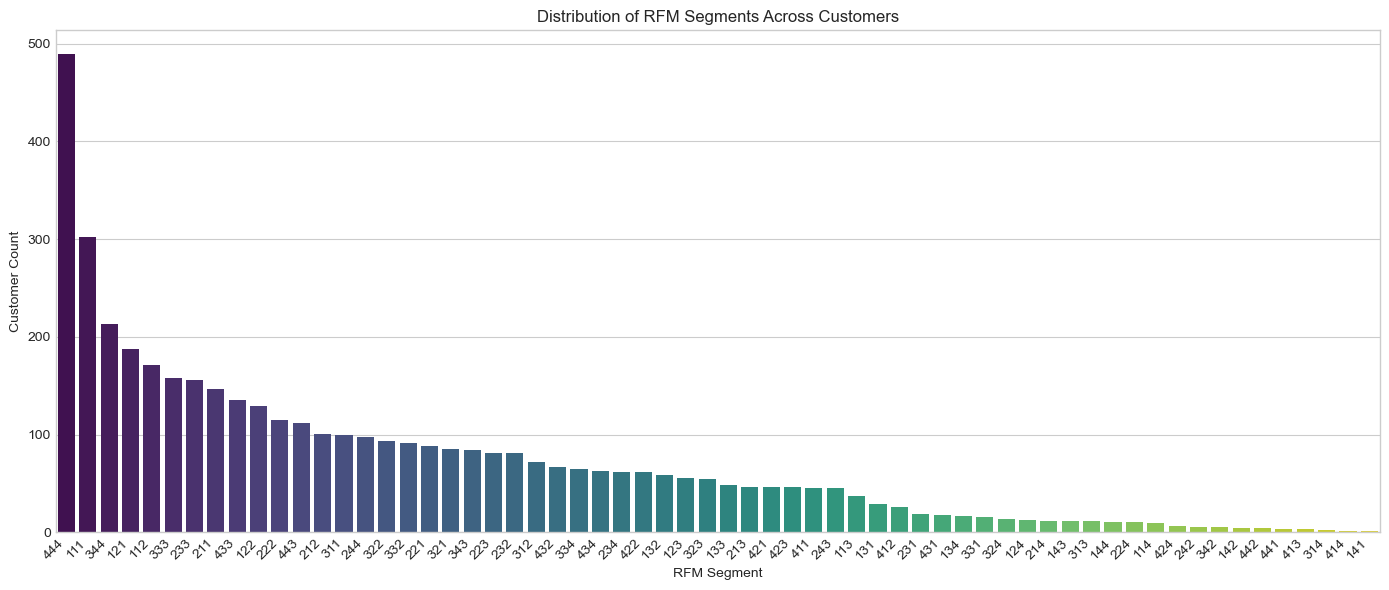

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count customers per RFM segment
rfm_segment_counts = rfm['RFM_Segment'].value_counts().reset_index()
rfm_segment_counts.columns = ['RFM_Segment', 'CustomerCount']

# Plot vertical bar chart with rotated labels
plt.figure(figsize=(14,6))  # Wider figure to reduce crowding
sns.barplot(data=rfm_segment_counts, x='RFM_Segment', y='CustomerCount', palette='viridis')
plt.title('Distribution of RFM Segments Across Customers')
plt.xlabel('RFM Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.tight_layout()
plt.show()

# Q2: What are the characteristics of different customer segments?

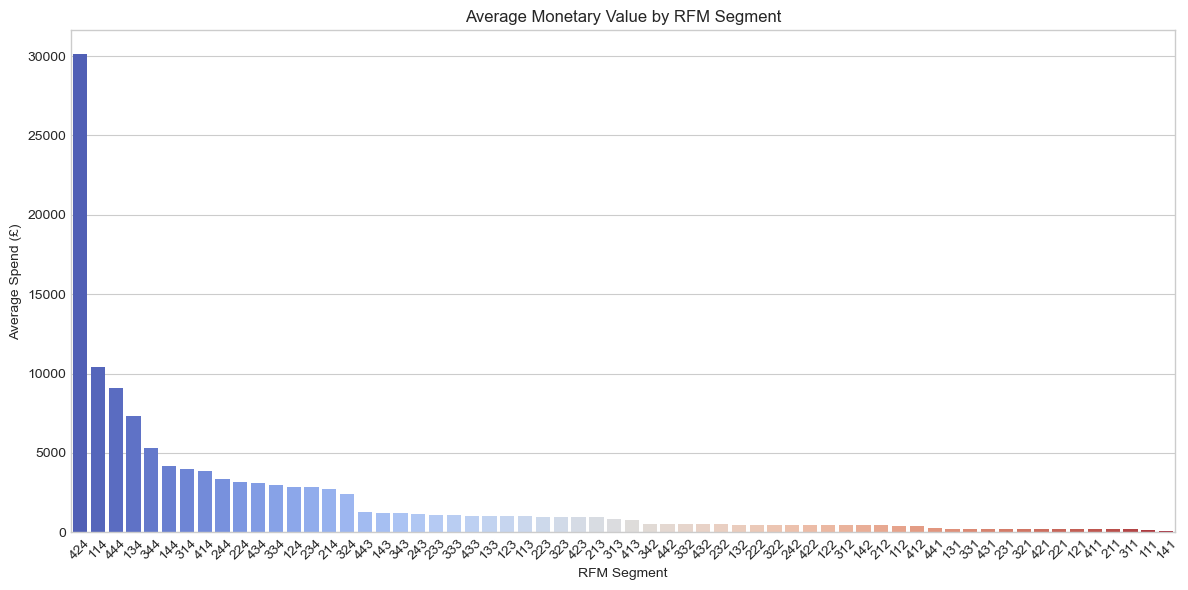

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by RFM segment and calculate average spend
rfm_segment_summary = rfm.groupby('RFM_Segment')['Monetary'].mean().reset_index()

# Sort segments by average spend
rfm_segment_summary = rfm_segment_summary.sort_values(by='Monetary', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=rfm_segment_summary, x='RFM_Segment', y='Monetary', palette='coolwarm')
plt.title('Average Monetary Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Average Spend (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Q3: Are there patterns in customer behavior over time?

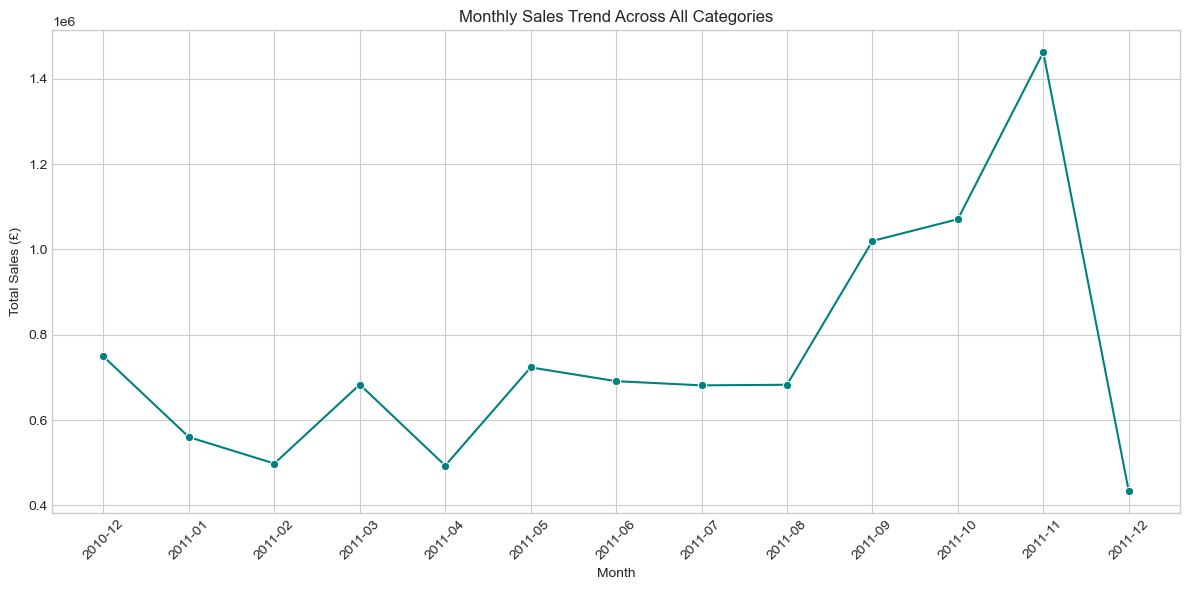

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert InvoiceDate to datetime if needed
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create MonthYear column
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Group by MonthYear and sum TotalPrice
monthly_sales = df.groupby('MonthYear')['TotalPrice'].sum().reset_index()

# Plot monthly sales trend
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='MonthYear', y='TotalPrice', marker='o', color='teal')
plt.title('Monthly Sales Trend Across All Categories')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Q4 What regions drive the most revenue?

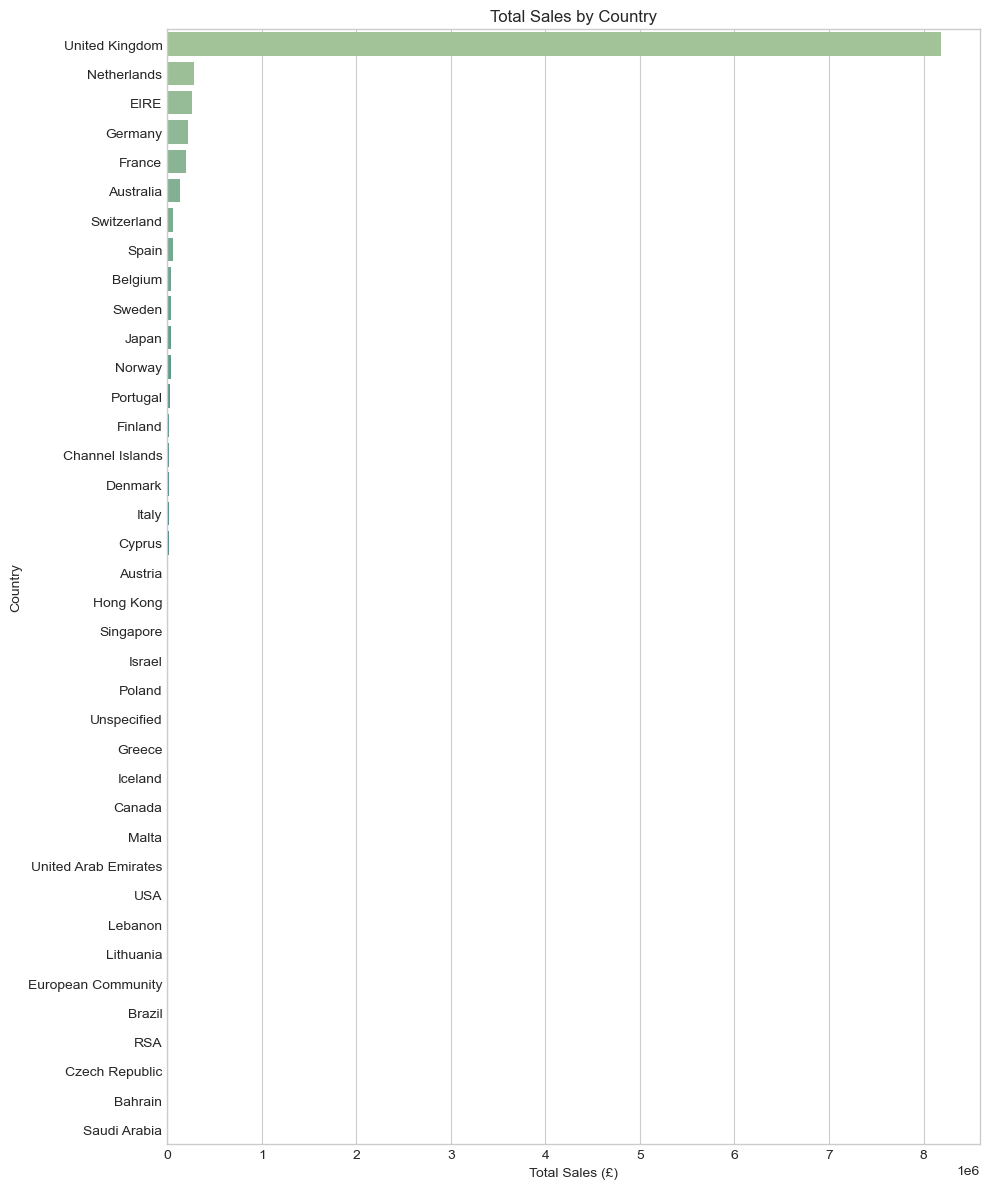

In [90]:
plt.figure(figsize=(10,12))  # Taller figure for vertical spacing
sns.barplot(data=country_sales, y='Country', x='TotalPrice', palette='crest')
plt.title('Total Sales by Country')
plt.xlabel('Total Sales (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

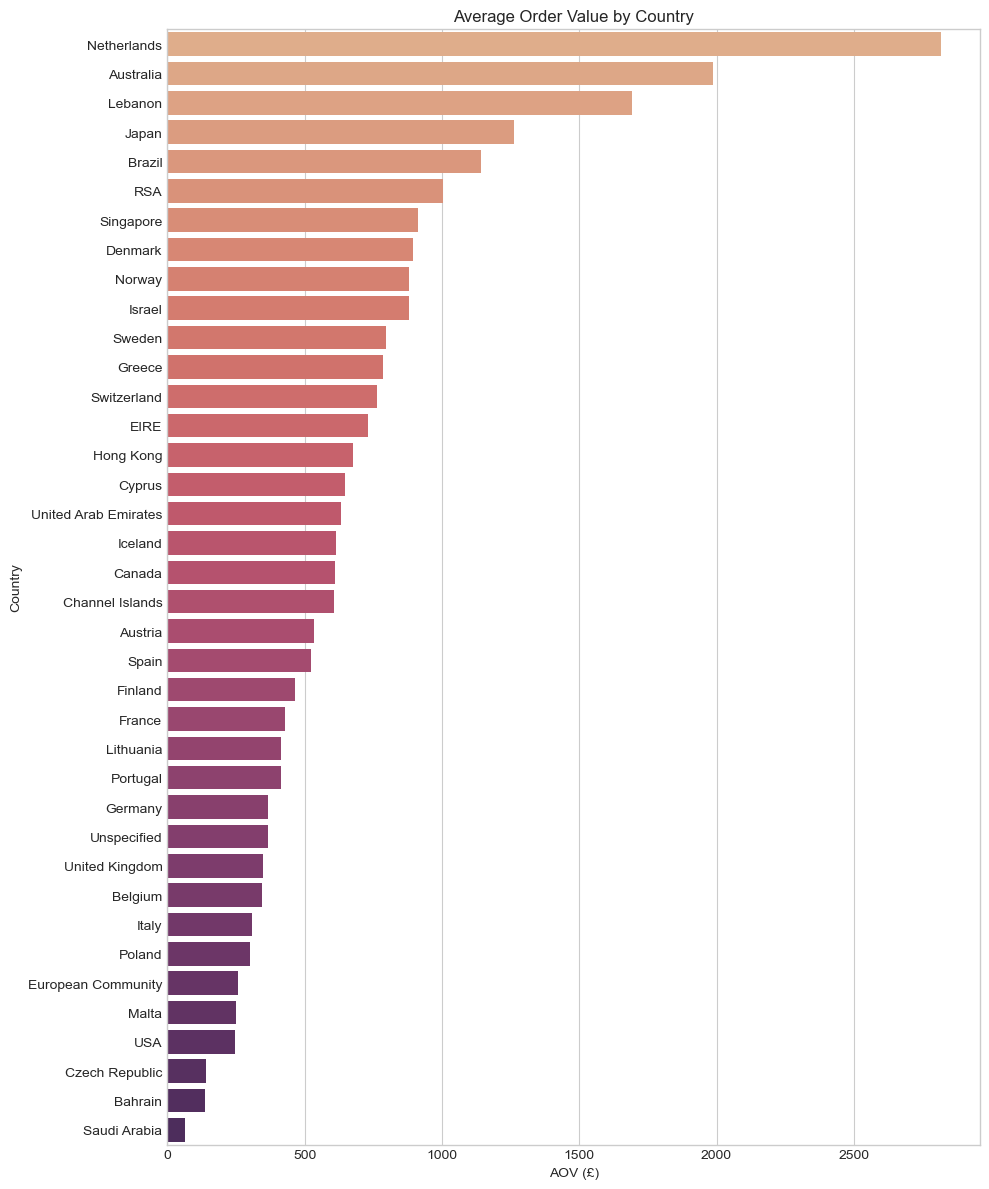

In [91]:
plt.figure(figsize=(10,12))
sns.barplot(data=aov_country, y='Country', x='AOV', palette='flare')
plt.title('Average Order Value by Country')
plt.xlabel('AOV (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

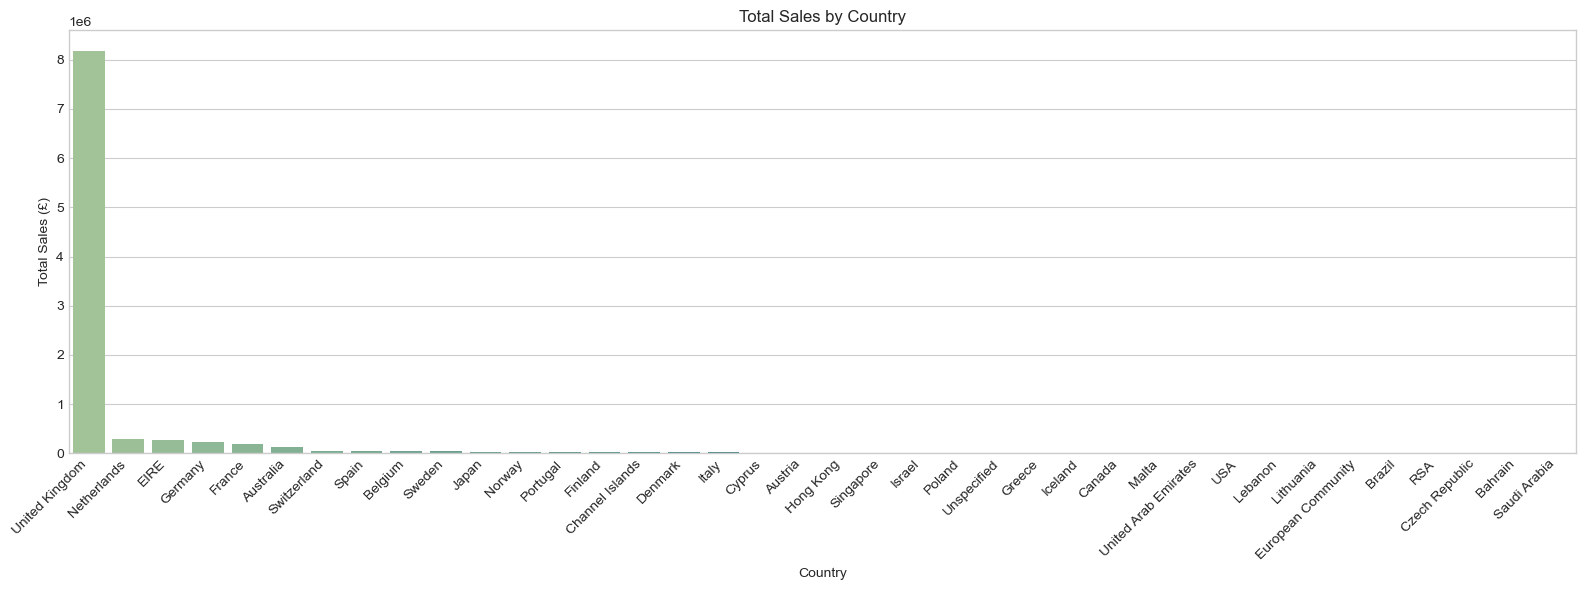

In [92]:
plt.figure(figsize=(16,6))  # Wider figure
sns.barplot(data=country_sales, x='Country', y='TotalPrice', palette='crest')
plt.xticks(rotation=45, ha='right')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()

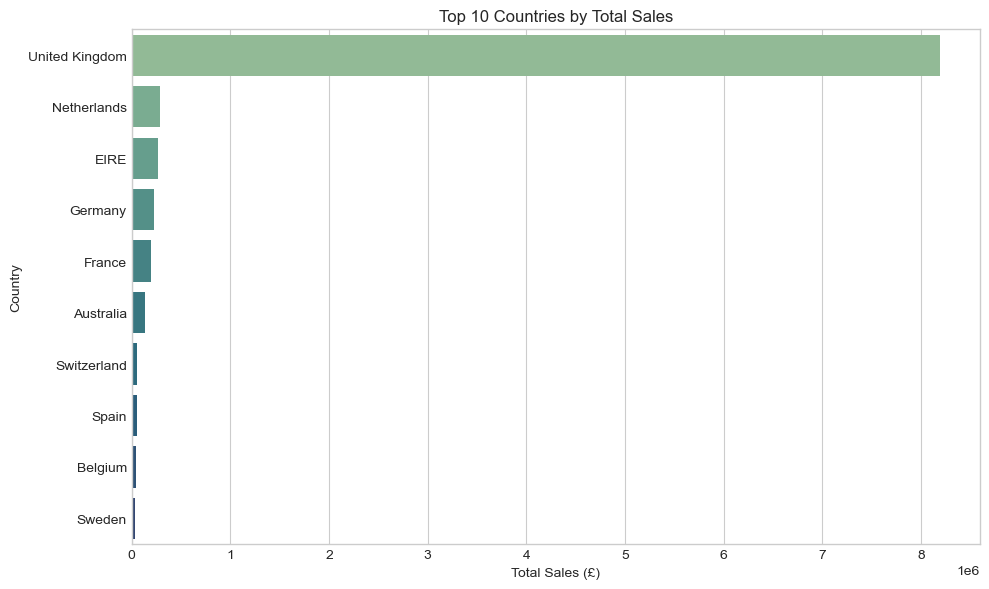

In [93]:
top_countries = country_sales.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_countries, y='Country', x='TotalPrice', palette='crest')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# Q5: Which product categories perform best?

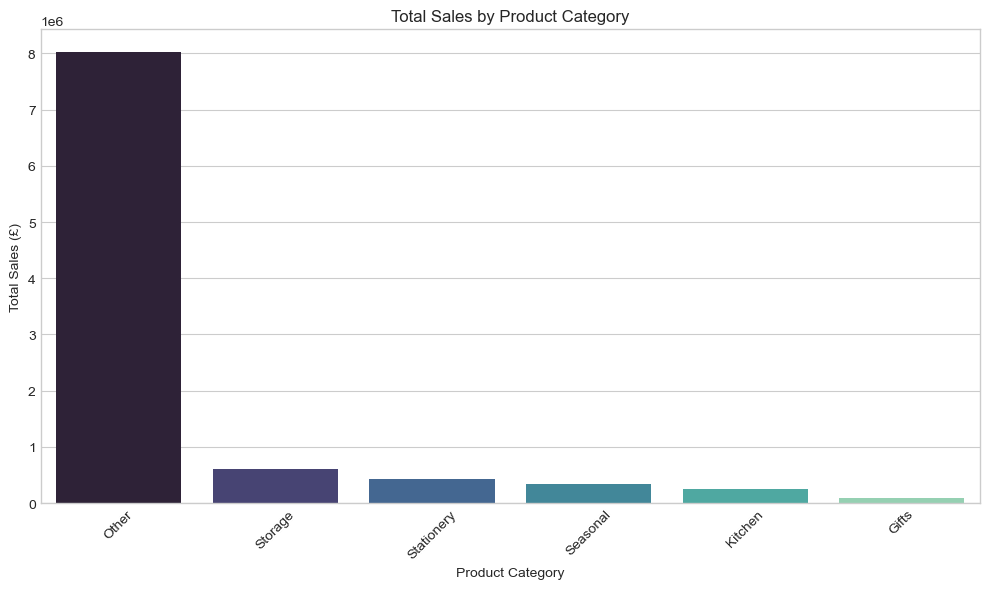

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by ProductCategory and sum TotalPrice
category_sales = df.groupby('ProductCategory')['TotalPrice'].sum().sort_values(ascending=False).reset_index()

# Plot total sales by category
plt.figure(figsize=(10,6))
sns.barplot(data=category_sales, x='ProductCategory', y='TotalPrice', palette='mako')
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Q6: How do sales vary by time period?

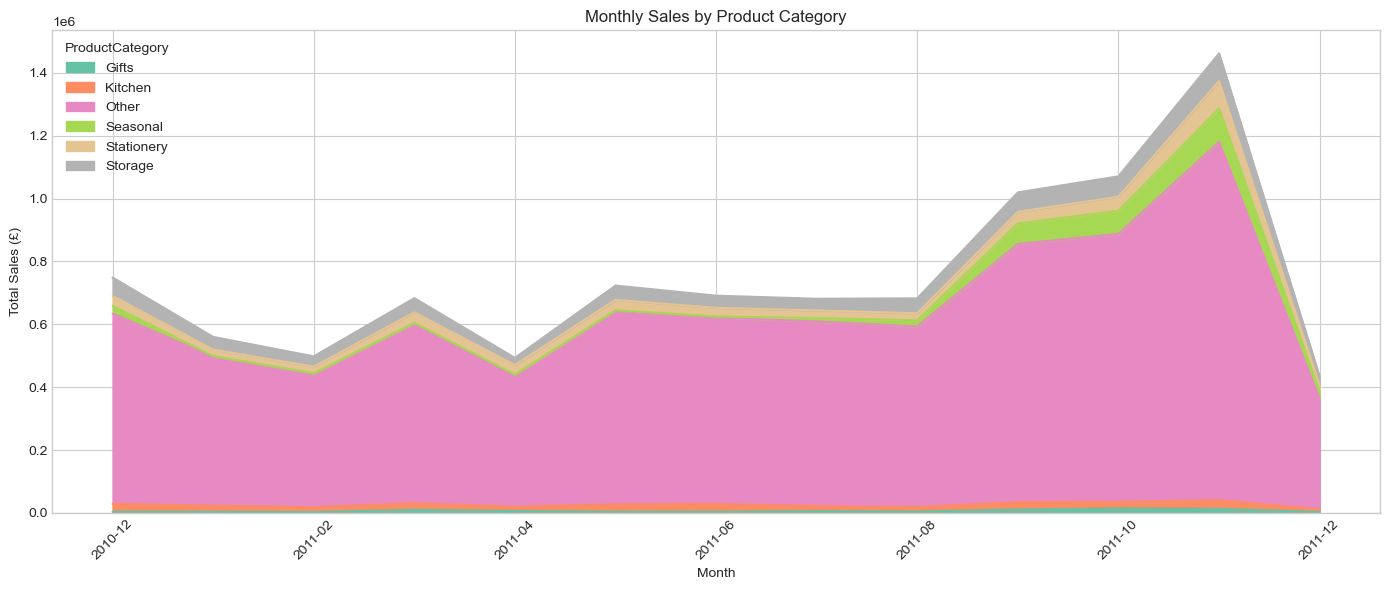

In [97]:
import matplotlib.pyplot as plt

# Group by MonthYear and ProductCategory
monthly_category_sales = df.groupby(['MonthYear', 'ProductCategory'])['TotalPrice'].sum().unstack().fillna(0)

# Plot stacked area chart
monthly_category_sales.plot.area(figsize=(14,6), colormap='Set2')
plt.title('Monthly Sales by Product Category')
plt.ylabel('Total Sales (£)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Q7: What are the top-selling products and categories?

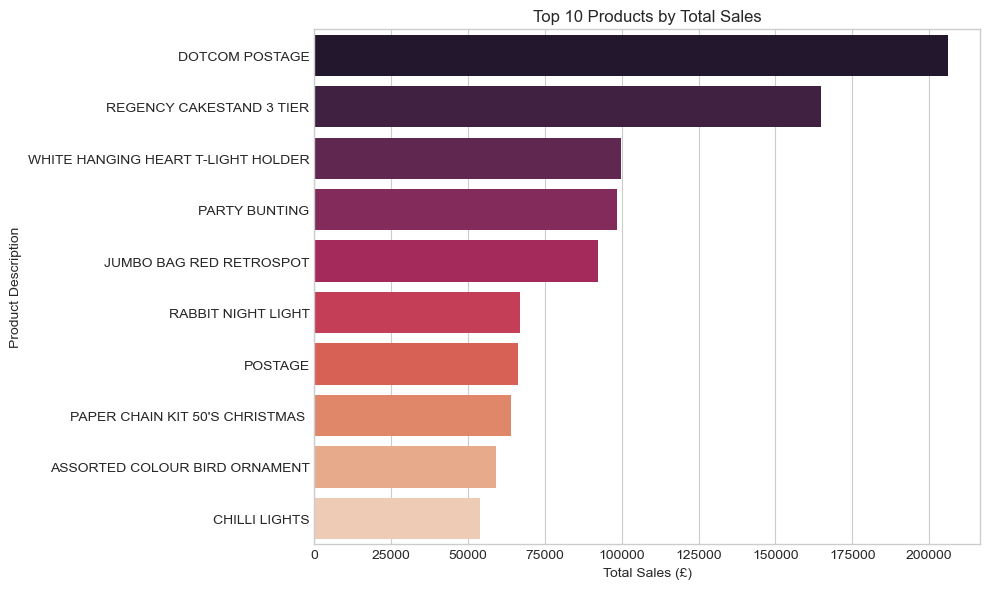

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by product description and sum total sales
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=top_products, y='Description', x='TotalPrice', palette='rocket')
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

# Q8: What is the average order value and how does it vary?

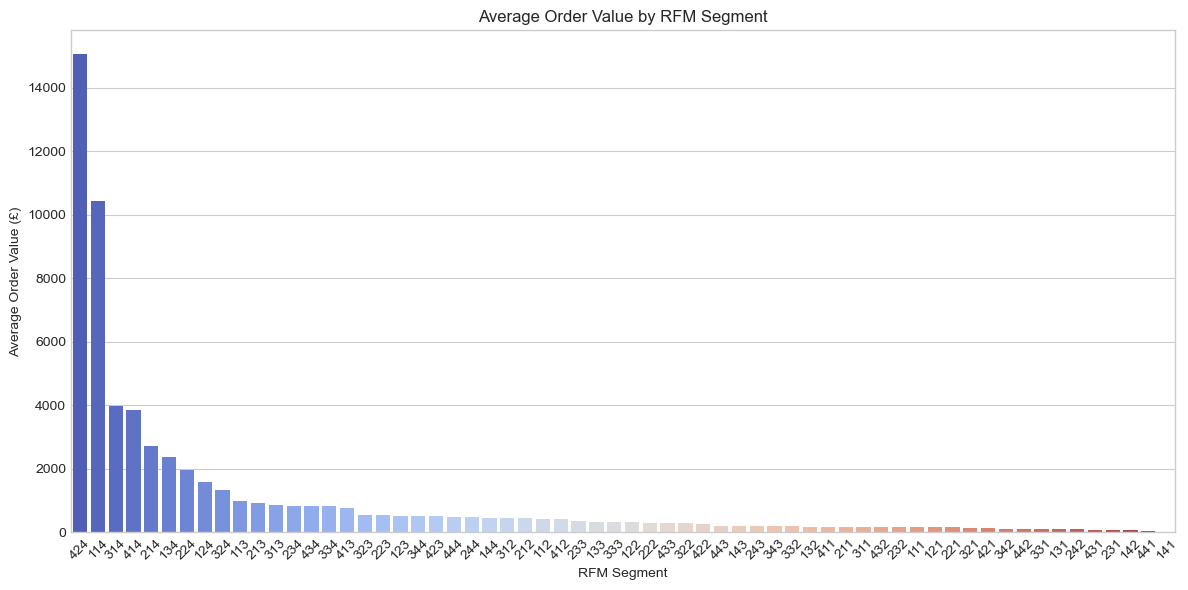

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate AOV per customer
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Group by RFM segment and calculate average AOV
aov_by_segment = rfm.groupby('RFM_Segment')['AOV'].mean().reset_index()
aov_by_segment = aov_by_segment.sort_values(by='AOV', ascending=False)

# Plot AOV by RFM segment
plt.figure(figsize=(12,6))
sns.barplot(data=aov_by_segment, x='RFM_Segment', y='AOV', palette='coolwarm')
plt.title('Average Order Value by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Average Order Value (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Q9: Are there loyalty or churn signals?

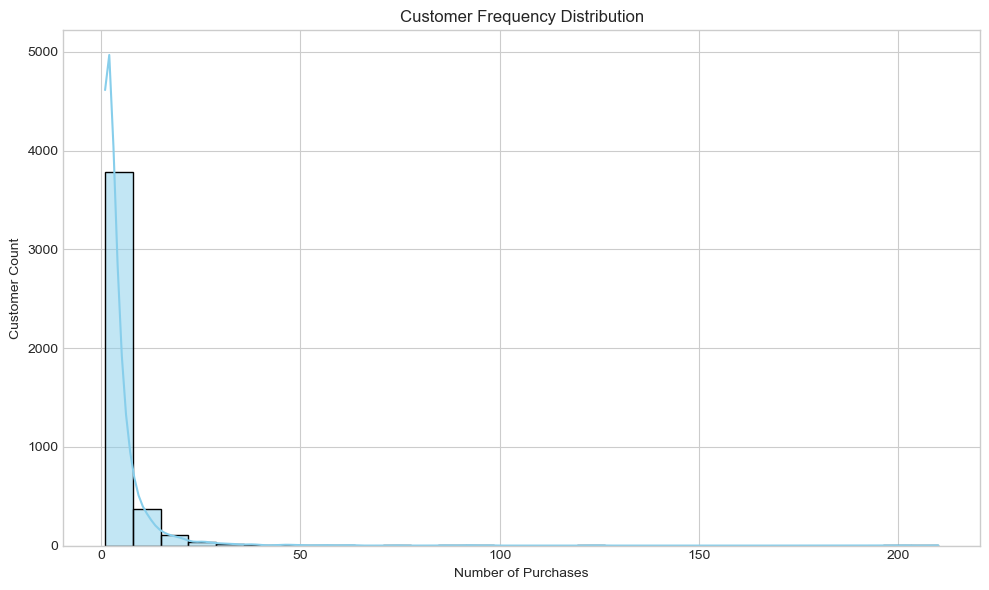

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Customer Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

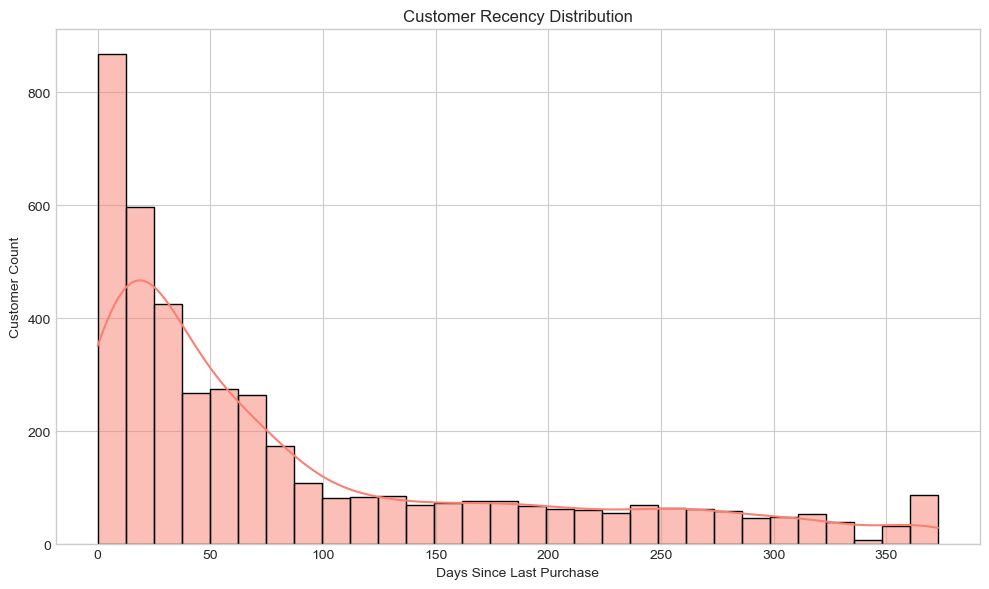

In [103]:
plt.figure(figsize=(10,6))
sns.histplot(rfm['Recency'], bins=30, kde=True, color='salmon', edgecolor='black')
plt.title('Customer Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

# Q10: What recommendations can we make based on the data?

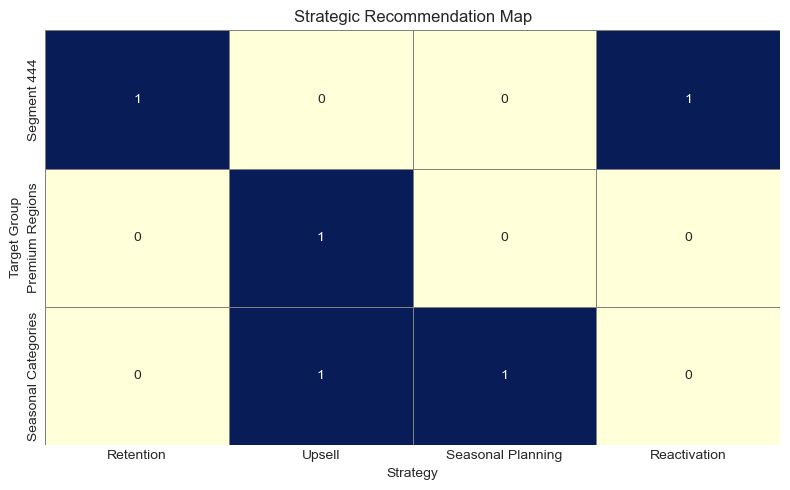

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a recommendation matrix manually
recommendation_data = {
    'Retention': [1, 0, 0],
    'Upsell': [0, 1, 1],
    'Seasonal Planning': [0, 0, 1],
    'Reactivation': [1, 0, 0]
}

index_labels = ['Segment 444', 'Premium Regions', 'Seasonal Categories']
recommendation_df = pd.DataFrame(recommendation_data, index=index_labels)

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(recommendation_df, annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Strategic Recommendation Map')
plt.xlabel('Strategy')
plt.ylabel('Target Group')
plt.tight_layout()
plt.show()